# 라이브러리 import

In [44]:
# Data Preprocessing Libraries
import pandas as pd
from pandas_gbq import read_gbq
import numpy as np
import ast
from collections import defaultdict
import platform
import concurrent.futures
import json

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Data Processing Libraries
from sklearn.model_selection import train_test_split

# Text Preprocessing Libraries
import re
from konlpy.tag import Okt

# Demensionality Reduction Libraries
from umap.umap_ import UMAP
from sklearn.decomposition import PCA

# Text Fature Extraction Libraries
from sentence_transformers import SentenceTransformer
from sklearn.metrics import pairwise_distances
from scipy.stats import spearmanr

# Unsupervised Learning Libraries
from sklearn.neighbors import NearestNeighbors

# Associtation Analysis Libraries
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules

# Network and Louvain Algorithm Libraries
import networkx as nx
import community.community_louvain as community_louvain

# Deep Learning Libraries
from transformers import AutoTokenizer, AutoModel
import torch

# Spark Libraries
from pyspark.sql import SparkSession 

# Google Cloud Libraries
import dotenv
from google.oauth2 import service_account
from google.cloud import bigquery
from vertexai.preview.generative_models import GenerativeModel
import vertexai
import time

# Ignore warnings
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="n_jobs value")

# 시스템에 따라 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux (Colab 포함)
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기

## ChatGPT가 알려준 데이터 불러오기 권장 사항

- 서비스 계정 인증 (선택적)

.env에서 서비스 계정 키를 불러오거나, 별도로 인증 파일을 로드해서 확실한 권한 제어 가능

> ```python
> from google.oauth2 import service_account
> credentials = service_account.Credentials.from_service_account_file("your-key.json")
> df = read_gbq(query, project_id=..., credentials=credentials)
> ```

- 쿼리 최적화 권장

BigQuery는 쿼리 단위 요금이기 때문에, SELECT * 대신 필요한 컬럼만 명시하고, 파티션/필터 조건을 활용하는 것이 좋습니다.

- 캐싱 여부 확인

pandas-gbq 기본 설정으로는 쿼리 캐싱이 적용되지 않으므로, 빈번하게 같은 쿼리를 날리는 경우 비용이 증가할 수 있습니다.

## pandas

In [2]:
# BigQuery에 업로드된 데이터 불러오기 (pandas)
def load_data_from_bigquery(query):
    try:
        df = read_gbq(query,
                      project_id=dotenv.get_key(dotenv.find_dotenv(), "GOOGLE_PROJECT_ID"),
                      dialect='standard'
                      )
        return df
    except Exception as e:
        print(f"Error loading data from BigQuery: {e}")
        return None

In [4]:
votes_tables = load_data_from_bigquery("SELECT table_name FROM `votes.INFORMATION_SCHEMA.TABLES`;")

Downloading: 100%|██████████|


In [5]:
hackle_tables = load_data_from_bigquery("SELECT table_name FROM `hackle.INFORMATION_SCHEMA.TABLES`;")

Downloading: 100%|██████████|


## spark

In [ ]:
# BigQuery에 업로드된 데이터 불러오기 (spark)
def load_data_from_bigquery_spark(query):
    spark = SparkSession.builder \
        .appName("BigQuery to Spark") \
        .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.24.0") \
        .getOrCreate()
    try:
        credentials = service_account.Credentials.from_service_account_file(
            dotenv.get_key(dotenv.find_dotenv(), "GOOGLE_APPLICATION_CREDENTIALS")
        )
        df = spark.read.format("bigquery") \
            .option("credentials", credentials) \
            .option("query", query) \
            .load()
        return df
    except Exception as e:
        print(f"Error loading data from BigQuery with Spark: {e}")
        return None

In [ ]:
votes_tables = load_data_from_bigquery_spark("SELECT table_name FROM `votes.INFORMATION_SCHEMA.TABLES`;")

In [ ]:
hackle_tables = load_data_from_bigquery_spark("SELECT table_name FROM `hackle.INFORMATION_SCHEMA.TABLES`;")

# 기본 통계량 함수 작성란

In [3]:
# 기본 통계량 (데이터의 크기, 타입, 결측치, describe 내용 확인) 출력 함수
def basic_information(df):
    print(f'data shape : {df.shape}')
    
    basic_info_df = pd.DataFrame(data=df.dtypes, columns=['dtypes'])
    basic_info_df['missing'] = df.isnull().sum().values
    basic_info_df['missing_rate (%)'] = df.isnull().sum().values / len(df) * 100
    basic_info_df['nunique'] = df.nunique().values

    # describe 통계량 (수치형/범주형 포함)
    desc_df = df.describe(include='all').transpose()

    # 수치형 항목만 해당되는 통계량 추가
    for col in ['mean', 'std', 'min','25%', '50%', '75%', 'max']:
        if col in desc_df.columns:
            basic_info_df[col] = desc_df[col]

    # 최빈값 및 해당 최빈값의 count
    basic_info_df['mode'] = {col: df[col].mode(dropna=True).iloc[0] if not df[col].mode(dropna=True).empty else None for col in df.columns}
    basic_info_df['mode_counts'] = {col: df[col].value_counts().max() if not df[col].value_counts().empty else 0 for col in df.columns}

    return basic_info_df

# votes 데이터베이스 확인

## head 출력

In [ ]:
# votes 테이블의 기본 정보 출력
for table in votes_tables['table_name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM `votes.{table}` LIMIT 5;"
    display(load_data_from_bigquery(query))

Table: polls_question
Downloading: 100%|██████████|


,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


Table: accounts_attendance
Downloading: 100%|██████████|


,id,attendance_date_list,user_id
0,7923,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1355335
1,38921,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",892265
2,777,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",913054
3,6557,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",947077
4,2534,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1233366


Table: polls_questionpiece
Downloading: 100%|██████████|


,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


Table: accounts_failpaymenthistory
Downloading: 100%|██████████|


,id,productId,phone_type,created_at,user_id
0,20,None,I,2023-05-15 16:26:51,1153256
1,21,None,I,2023-05-16 03:16:37,1230712
2,22,None,I,2023-05-16 06:40:04,1277817
3,23,None,I,2023-05-16 07:40:32,1254768
4,26,None,I,2023-05-16 11:31:51,1189806


Table: polls_questionset
Downloading: 100%|██████████|


,id,question_piece_id_list,opening_time,status,created_at,user_id
0,7993167,"[79931958, 79931960, 79931962, 79931966, 79931...",2023-05-17 00:22:16,C,2023-05-16 23:42:16,841333
1,8298931,"[82989582, 82989587, 82989592, 82989596, 82989...",2023-05-17 09:54:57,C,2023-05-17 09:14:57,845326
2,20617202,"[206172781, 206172782, 206172783, 206172784, 2...",2023-07-29 16:13:18,C,2023-07-29 15:33:18,847375
3,20017608,"[200176841, 200176842, 200176843, 200176844, 2...",2023-06-16 15:13:10,C,2023-06-16 14:33:10,849438
4,20673673,"[206737491, 206737492, 206737493, 206737494, 2...",2023-08-10 09:20:44,C,2023-08-10 08:40:44,849451


Table: accounts_user_contacts
Downloading: 100%|██████████|


,id,contacts_count,invite_user_id_list,user_id
0,1817700,1,[887254],945228
1,294336,4,[876443],971857
2,161592,5,[879138],890096
3,500886,5,[858396],871299
4,1270942,5,[1548321],1555658


Table: accounts_group
Downloading: 100%|██████████|


,id,grade,class_num,school_id
0,1,1,1,1
1,227,1,20,1
2,660,1,7,1
3,1184,1,5,1
4,1191,1,8,1


Table: accounts_user
Downloading: 100%|██████████|


,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


Table: accounts_blockrecord
Downloading: 100%|██████████|


,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,6,그냥...,2023-05-05 05:21:52,883696,883511
2,7,그냥...,2023-05-05 06:40:34,871349,870177
3,14,그냥...,2023-05-05 13:04:52,885794,879662
4,21,그냥...,2023-05-05 15:36:34,887434,881108


Table: accounts_userwithdraw
Downloading: 100%|██████████|


,id,reason,created_at
0,47374,admin,2023-05-28 15:07:43
1,47376,admin,2023-05-29 06:22:53
2,47377,admin,2023-05-29 06:43:36
3,47379,admin,2023-05-29 08:33:47
4,47380,admin,2023-05-29 09:15:01


Table: accounts_friendrequest
Downloading: 100%|██████████|


,id,status,created_at,updated_at,receive_user_id,send_user_id
0,10803451,A,2023-05-16 11:47:10,2023-05-17 13:55:36,1186094,1323197
1,10803477,A,2023-05-16 11:47:10,2023-05-16 14:23:29,1276512,1320204
2,10805049,A,2023-05-16 11:48:18,2023-05-16 13:02:12,1320432,1115450
3,10806004,A,2023-05-16 11:49:01,2023-05-16 11:52:33,1321751,1322938
4,10807567,A,2023-05-16 11:50:07,2023-05-16 15:01:54,1145230,1286765


Table: event_receipts
Downloading: 100%|██████████|


,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500


Table: polls_questionreport
Downloading: 100%|██████████|


,id,reason,created_at,question_id,user_id
0,4852,그냥 싫어,2023-05-07 12:14:13,99,894226
1,4971,그냥 싫어,2023-05-07 13:43:20,99,906185
2,5389,그냥 싫어,2023-05-08 02:16:54,99,944035
3,7884,그냥 싫어,2023-05-09 14:19:10,99,981801
4,11094,그냥 싫어,2023-05-11 13:26:01,99,887923


Table: events
Downloading: 100%|██████████|


,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59
2,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45


Table: accounts_paymenthistory
Downloading: 100%|██████████|


,id,productId,phone_type,created_at,user_id
0,89584,heart.777,A,2023-06-06 04:58:49,835888
1,89585,heart.200,A,2023-06-06 04:59:22,835888
2,2403,heart.777,A,2023-05-14 04:22:44,837641
3,79774,heart.777,A,2023-05-29 10:13:55,837737
4,195,heart.777,A,2023-05-13 23:10:10,837842


Table: accounts_userquestionrecord
Downloading: 100%|██████████|


,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,945319,I,2023-04-29 13:22:05,849995,132,851717,1213085,1,P,2023-05-06 10:31:30,0,3
1,978922,I,2023-04-29 14:49:06,849922,180,849450,1235436,1,N,2023-04-29 14:49:06,0,3
2,1095692,I,2023-04-30 03:29:48,850031,132,850229,1395859,1,N,2023-04-30 03:29:48,0,3
3,1167181,I,2023-04-30 07:43:10,856172,116,857422,1509130,1,N,2023-04-30 07:43:10,0,3
4,1171173,I,2023-04-30 07:58:36,855039,132,855117,1511169,1,N,2023-04-30 07:58:36,0,3


Table: accounts_school
Downloading: 100%|██████████|


,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,6,충청북도 충주시,200,H
2,7,충청북도 충주시,114,H
3,13,충청북도 충주시,80,H
4,16,충청북도 충주시,143,H


Table: accounts_pointhistory
Downloading: 100%|██████████|


,id,delta_point,created_at,user_id,user_question_record_id
0,145203381,-500,2023-05-18 12:24:21,1228792,69029243.0
1,145379907,-500,2023-05-18 12:33:59,1159163,71772936.0
2,145400847,-500,2023-05-18 12:35:09,1243371,40846522.0
3,145439633,-500,2023-05-18 12:37:14,1273533,70891824.0
4,145467849,-500,2023-05-18 12:38:46,1295255,69224499.0


Table: accounts_nearbyschool
Downloading: 100%|██████████|


,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


Table: polls_usercandidate
Downloading: 100%|██████████|


,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446


Table: accounts_timelinereport
Downloading: 100%|██████████|


,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,4794,광고,2023-05-10 14:27:44,917587,1084275,18272641
1,7168,광고,2023-05-12 14:54:46,967873,1184397,28992803
2,7169,광고,2023-05-12 14:54:52,967873,1184397,28992803
3,9998,광고,2023-05-14 16:49:58,1207784,1214760,46645583
4,10257,광고,2023-05-15 06:08:04,1250642,1228033,48820574


## 기본 정보 출력

In [ ]:
# votes 테이블의 요약, 결측치, 타입 등 기본 정보 출력
for table in votes_tables['table_name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM `votes.{table}`;"
    display(basic_information(load_data_from_bigquery(query)))

Table: polls_question
Downloading: 100%|██████████|
data shape : (5025, 3)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,5025,2619.897512,1452.438472,99.0,1365.0,2621.0,3877.0,5133.0,99,1
question_text,object,0,0.0,3903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vote,56
created_at,datetime64[us],0,0.0,644,2023-05-26 17:49:11.666268,NaN,2023-03-31 15:22:53,2023-05-15 14:03:03,2023-06-02 08:06:53,2023-06-06 06:10:14,2023-06-06 06:15:52,2023-06-06 06:15:42,82


Table: accounts_attendance
Downloading: 100%|██████████|
data shape : (349637, 3)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,349637,180550.143772,104168.322237,1.0,90432.0,180749.0,270674.0,360505.0,1,1
attendance_date_list,object,0,0.0,128837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],20945
user_id,Int64,0,0.0,349637,1247187.288568,212798.63273,832151.0,1065813.0,1261234.0,1437486.0,1583730.0,832151,1


Table: polls_questionpiece
Downloading: 100%|██████████|
data shape : (1265476, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,1265476,76580010.680432,59129238.708104,998458.0,20292595.75,68465330.0,121266195.5,208385230.0,998458,1
is_voted,Int64,0,0.0,2,0.963027,0.188697,0.0,1.0,1.0,1.0,1.0,1,1218687
created_at,datetime64[us],0,0.0,162155,2023-05-17 13:39:58.427318,NaN,2023-04-28 12:27:22,2023-05-09 21:50:54,2023-05-15 14:18:31.500000,2023-05-22 09:56:44,2024-05-07 11:32:30,2023-05-20 14:45:37,37
question_id,Int64,0,0.0,4944,713.359777,670.681537,99.0,278.0,477.0,982.0,5133.0,170,2030
is_skipped,Int64,0,0.0,2,0.000891,0.029829,0.0,0.0,0.0,0.0,1.0,0,1264349


Table: accounts_failpaymenthistory
Downloading: 100%|██████████|
data shape : (163, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.000000,163,89.828221,48.494316,6.0,48.5,89.0,131.5,174.0,6,1
productId,object,107,65.644172,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,heart.777,49
phone_type,object,0,0.000000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,107
created_at,datetime64[us],0,0.000000,162,2023-05-27 11:32:20.828220,NaN,2023-05-14 05:49:22,2023-05-18 11:34:05,2023-05-22 08:54:33,2023-05-29 12:58:21.500000,2023-09-17 09:12:53,2023-09-17 09:12:53,2
user_id,Int64,0,0.000000,160,1263684.779141,182463.595784,834112.0,1152703.5,1273301.0,1398432.0,1575434.0,927108,2


Table: polls_questionset
Downloading: 100%|██████████|
data shape : (158384, 6)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,158384,7641273.830696,5943689.973322,99817.0,1953393.25,6757335.0,12175103.25,20838446.0,99817,1
question_piece_id_list,object,0,0.0,158384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1000018, 1000019, 1000020, 1000021, 1000022, ...",1
opening_time,datetime64[us],0,0.0,151839,2023-05-17 13:25:41.180415,NaN,2023-04-28 12:27:22,2023-05-09 15:46:49.500000,2023-05-15 13:43:55.500000,2023-05-22 11:43:24.500000,2024-05-07 12:12:30,2023-04-29 11:22:43,4
status,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,153411
created_at,datetime64[us],0,0.0,151940,2023-05-17 12:43:12.170648,NaN,2023-04-28 12:27:23,2023-05-09 14:58:05.500000,2023-05-15 13:04:46.500000,2023-05-22 11:04:03,2024-05-07 11:32:30,2023-05-06 14:24:06,4
user_id,Int64,0,0.0,4972,1106751.980939,207861.209058,838023.0,884747.0,1117999.0,1261250.0,1583358.0,952220,370


Table: accounts_user_contacts
Downloading: 100%|██████████|
data shape : (5063, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,5063,2840906.78807,2895428.210201,259.0,747597.0,1580135.0,4201597.5,14608267.0,259,1
contacts_count,Int64,0,0.0,87,25.986174,13.601434,0.0,16.0,24.0,34.0,114.0,19,191
invite_user_id_list,object,0,0.0,928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],3905
user_id,Int64,0,0.0,5063,1114789.066364,218770.170387,847375.0,885515.5,1119987.0,1278826.0,1583629.0,847375,1


Table: accounts_group
Downloading: 100%|██████████|
data shape : (84515, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,84515,42279.376087,24400.96263,1.0,21147.5,42279.0,63411.5,84546.0,1,1
grade,Int64,0,0.0,5,2.113992,0.754896,1.0,2.0,2.0,3.0,20.0,2,35581
class_num,Int64,0,0.0,22,5.318606,4.089901,0.0,2.0,4.0,7.0,41.0,1,12125
school_id,Int64,0,0.0,5604,3079.496468,1675.036093,1.0,1752.0,3023.0,4620.0,5965.0,3283,49


Table: accounts_user
Downloading: 100%|██████████|
data shape : (677085, 16)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.000000,677085,1212969.125237,213897.052019,831956.0,1028075.0,1211729.0,1397906.0,1583733.0,831956,1
is_superuser,Int64,0,0.000000,2,0.000003,0.001719,0.0,0.0,0.0,0.0,1.0,0,677083
is_staff,Int64,0,0.000000,2,0.000004,0.002105,0.0,0.0,0.0,0.0,1.0,0,677082
gender,object,2,0.000295,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,396665
point,Int64,0,0.000000,14258,3039.144837,1076019.94305,0.0,400.0,965.0,2183.0,885000006.0,300,8936
friend_id_list,object,0,0.000000,674117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],2874
is_push_on,Int64,0,0.000000,2,0.843098,0.363709,0.0,1.0,1.0,1.0,1.0,1,570849
created_at,datetime64[us],0,0.000000,677082,2023-05-15 22:46:01.709212,NaN,2023-03-29 03:44:14.047130,2023-05-09 01:35:23.126587,2023-05-13 10:50:57.476214,2023-05-20 07:49:47.800350,2024-05-09 08:31:17.710824,2023-05-12 04:20:25.151806,2
block_user_id_list,object,0,0.000000,11685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],664042
hide_user_id_list,object,0,0.000000,74995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],598352


Table: accounts_blockrecord
Downloading: 100%|██████████|
data shape : (19482, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,19482,12694.563495,7220.338199,1.0,6514.25,12731.0,18984.75,25361.0,1,1
reason,object,0,0.0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,모르는 사람임,9640
created_at,datetime64[us],0,0.0,19364,2023-05-25 19:12:26.516579,NaN,2023-05-04 23:01:53,2023-05-14 02:19:01,2023-05-22 11:37:20,2023-05-28 11:04:33,2024-05-06 13:03:37,2023-05-09 11:55:43,3
block_user_id,Int64,0,0.0,16240,1183575.866235,204951.681645,832740.0,1001336.0,1173390.0,1357468.25,1582869.0,898020,76
user_id,Int64,0,0.0,12552,1175780.405708,204318.852573,837615.0,989041.0,1160725.5,1345757.75,1583612.0,1526194,171


Table: accounts_userwithdraw
Downloading: 100%|██████████|
data shape : (70764, 3)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,70764,35499.063154,20439.604727,42.0,17803.75,35498.5,53199.25,70893.0,42,1
reason,object,0,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,기타 이유,40301
created_at,datetime64[us],0,0.0,69888,2023-06-12 06:34:26.762464,NaN,2023-03-29 13:22:12,2023-05-12 06:28:54.250000,2023-05-20 15:50:53.500000,2023-06-14 12:13:03.500000,2024-05-09 08:49:06,2023-05-07 12:58:16,3


Table: accounts_friendrequest
Downloading: 100%|██████████|
data shape : (17147175, 6)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,17147175,9855564.676715,5675224.681984,7.0,4940746.5,9810449.0,14775984.5,19692979.0,7,1
status,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,12878407
created_at,datetime64[us],0,0.0,2349736,2023-05-17 19:14:14.416624,NaN,2023-04-17 18:29:11,2023-05-10 10:53:21,2023-05-15 10:38:56,2023-05-22 14:28:30,2024-05-09 09:21:47,2023-05-07 10:30:02,668
updated_at,datetime64[us],0,0.0,2941770,2023-05-19 03:18:26.881182,NaN,2023-04-17 18:29:11,2023-05-11 03:51:13,2023-05-16 10:24:42,2023-05-23 21:37:16,2024-05-09 09:21:47,2023-05-07 10:30:02,216
receive_user_id,Int64,0,0.0,660841,1154812.124189,201954.707116,831962.0,973708.0,1138343.0,1317869.0,1583731.0,909685,218
send_user_id,Int64,0,0.0,649072,1215895.337257,214348.591142,831962.0,1029359.0,1213751.0,1405678.0,1583732.0,1533716,1816


Table: event_receipts
Downloading: 100%|██████████|
data shape : (309, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,309,160.964401,92.065029,2.0,82.0,161.0,239.0,321.0,2,1
created_at,datetime64[us],0,0.0,309,2023-07-24 01:53:59.954692,NaN,2023-06-22 09:25:16,2023-07-10 16:58:20,2023-07-20 12:24:28,2023-07-29 09:38:22,2023-11-21 12:03:02,2023-06-22 09:25:16,1
event_id,Int64,0,0.0,3,1.249191,0.563536,1.0,1.0,1.0,1.0,3.0,1,252
user_id,Int64,0,0.0,308,1179714.640777,217198.132845,837836.0,999816.0,1139491.0,1325911.0,1579064.0,1577954,2
plus_point,Int64,0,0.0,2,559.87055,162.592579,500.0,500.0,500.0,500.0,1000.0,500,272


Table: polls_questionreport
Downloading: 100%|██████████|
data shape : (51424, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,51424,28027.358587,16163.108294,1.0,14020.75,28047.5,42084.25,55767.0,1,1
reason,object,0,0.0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,그냥 싫어,28446
created_at,datetime64[us],0,0.0,50693,2023-05-21 22:12:41.641121,NaN,2023-04-19 06:20:35,2023-05-13 01:36:21.250000,2023-05-18 14:33:45,2023-05-26 08:45:25,2024-05-05 14:56:25,2023-05-21 10:01:53,4
question_id,Int64,0,0.0,3135,733.099098,666.021729,99.0,305.0,494.0,1021.0,5110.0,111,988
user_id,Int64,0,0.0,22171,1168246.717642,208247.108978,832340.0,978481.0,1160251.0,1351295.0,1583634.0,1441146,865


Table: events
Downloading: 100%|██████████|
data shape : (3, 6)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,3,2.0,1.0,1.0,1.5,2.0,2.5,3.0,1,1
title,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,예고 영상 기대평 이벤트,1
plus_point,Int64,0,0.0,2,666.666667,288.675135,500.0,500.0,500.0,750.0,1000.0,500,2
event_type,object,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FCFS,3
is_expired,Int64,0,0.0,1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1,3
created_at,datetime64[us],0,0.0,3,2023-08-07 20:15:27.333333,NaN,2023-06-20 11:56:38,2023-07-14 21:50:11.500000,2023-08-08 07:43:45,2023-09-01 00:24:52,2023-09-24 17:05:59,2023-06-20 11:56:38,1


Table: accounts_paymenthistory
Downloading: 100%|██████████|
data shape : (95140, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,95140,49136.797572,28366.854064,6.0,24531.75,49176.5,73740.25,98078.0,6,1
productId,object,0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,heart.777,57873
phone_type,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,61632
created_at,datetime64[us],0,0.0,90243,2023-05-27 21:47:32.003742,NaN,2023-05-13 21:28:34,2023-05-16 11:48:44.750000,2023-05-21 12:40:45.500000,2023-05-27 13:02:52.250000,2024-05-08 14:12:45,2023-09-13 16:36:26,6
user_id,Int64,0,0.0,59192,1256911.87799,191124.313895,833041.0,1116654.0,1270988.0,1417660.0,1583632.0,1527451,60


Table: accounts_userquestionrecord
Downloading: 100%|██████████|
data shape : (1217558, 12)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,1217558,59572979.018822,46081927.886242,771777.0,15539652.75,53026805.0,94809596.25,161666464.0,771777,1
status,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,1156322
created_at,datetime64[us],0,0.0,916830,2023-05-17 12:51:25.947101,NaN,2023-04-28 12:27:49,2023-05-10 01:42:11,2023-05-15 15:43:01.500000,2023-05-22 11:01:03.750000,2024-05-08 01:36:18,2023-05-13 02:14:18,9
chosen_user_id,Int64,0,0.0,15426,1092603.584565,202758.478202,833112.0,883692.0,1091749.0,1235698.0,1579422.0,913265,1239
question_id,Int64,0,0.0,4805,684.389544,625.039927,99.0,275.0,469.0,942.0,5133.0,170,1996
user_id,Int64,0,0.0,4849,1105789.856924,206270.380697,838023.0,884619.0,1117537.0,1259186.0,1583358.0,849103,2786
question_piece_id,Int64,0,0.0,1217558,74132114.86932,57572369.476189,998458.0,18541420.5,66168425.5,117673456.75,208351468.0,998458,1
has_read,Int64,0,0.0,2,0.555153,0.496949,0.0,0.0,1.0,1.0,1.0,1,675931
answer_status,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1097932
answer_updated_at,datetime64[us],0,0.0,915926,2023-05-17 13:44:38.920360,NaN,2023-04-28 12:27:49,2023-05-10 02:38:44.750000,2023-05-15 16:29:08.500000,2023-05-22 11:41:54.750000,2024-05-08 01:36:18,2023-05-14 13:23:01,9


Table: accounts_school
Downloading: 100%|██████████|
data shape : (5951, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,5951,2981.026046,1719.08402,4.0,1493.5,2981.0,4469.5,5965.0,4,1
address,object,0,0.0,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경기도 화성시,78
student_count,Int64,0,0.0,433,113.772979,102.863428,0.0,16.0,97.0,183.0,578.0,0,387
school_type,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,3290


Table: accounts_pointhistory
Downloading: 100%|██████████|
data shape : (2338918, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.000000,2338918,126536375.311562,96109918.359378,790629.0,41125051.25,112397137.5,198205120.5,340672375.0,790629,1
delta_point,Int64,0,0.000000,44,0.861086,58.858493,-1000.0,7.0,10.0,13.0,1000.0,6,203479
created_at,datetime64[us],0,0.000000,985371,2023-05-18 03:06:43.825683,NaN,2023-04-28 12:27:49,2023-05-11 04:37:02,2023-05-16 07:29:11,2023-05-22 13:47:48.750000,2024-05-08 01:36:18,2023-05-14 15:01:54,18
user_id,Int64,0,0.000000,5037,1111554.416328,202442.944236,838023.0,886189.0,1126012.0,1260221.0,1583358.0,849103,2976
user_question_record_id,float64,2992,0.127922,1217554,61418034.598117,45319697.06178,771777.0,20885605.5,55406136.0,95558554.0,161666464.0,3398691.0,6


Table: accounts_nearbyschool
Downloading: 100%|██████████|
data shape : (59500, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,59500,148770.5,17176.314845,119021.0,133895.75,148770.5,163645.25,178520.0,119021.0,1
distance,float64,0,0.0,32006,0.055338,0.604024,0.0,0.011484,0.021658,0.064555,49.296594,0.0,6214
nearby_school_id,Int64,0,0.0,5950,2976.695882,1706.965231,4.0,1518.0,2973.0,4448.0,5964.0,4497.0,22
school_id,Int64,0,0.0,5950,2980.524538,1718.663078,4.0,1493.0,2980.5,4469.0,5964.0,4.0,10


Table: polls_usercandidate
Downloading: 100%|██████████|
data shape : (4769609, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,4769609,238868397.391241,184489263.091847,3088872.0,62703391.0,212670022.0,380021511.0,646672584.0,3088872,1
created_at,datetime64[us],0,0.0,917071,2023-05-17 13:57:52.437727,NaN,2023-04-28 12:27:49,2023-05-10 02:49:19,2023-05-15 16:15:12,2023-05-22 11:33:33,2024-05-08 01:36:18,2023-05-17 13:45:43,44
question_piece_id,Int64,0,0.0,1217589,74302481.038724,57619589.580503,998458.0,18916946.0,66396553.0,117887593.0,208351468.0,9494270,16
user_id,Int64,0,0.0,19994,1090240.982971,201819.002037,833112.0,883590.0,1087460.0,1233969.0,1580629.0,860304,4226


Table: accounts_timelinereport
Downloading: 100%|██████████|
data shape : (208, 6)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,208,9786.269231,5713.767759,28.0,6123.75,10095.0,14182.25,23108.0,28,1
reason,object,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,허위 사실 언급,80
created_at,datetime64[us],0,0.0,208,2023-05-15 08:13:50.278846,NaN,2023-05-06 04:44:57,2023-05-11 16:41:43.500000,2023-05-15 01:23:29,2023-05-18 18:01:18,2023-06-02 08:30:06,2023-05-06 04:44:57,1
reported_user_id,Int64,0,0.0,125,1132496.875,169412.066968,837235.0,966470.25,1144432.0,1225963.0,1562736.0,1138757,15
user_id,Int64,0,0.0,115,1159945.668269,180095.938183,834089.0,967120.25,1184397.0,1291813.0,1548002.0,1343904,19
user_question_record_id,Int64,0,0.0,163,49325579.326923,33112807.364359,3920588.0,24611783.5,47403268.0,71795781.0,140765885.0,78776644,14


# hackle 데이터베이스 확인

## head 출력

In [ ]:
# hackle 테이블의 기본 정보 출력
for table in hackle_tables['table_name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM `hackle.{table}` LIMIT 5;"
    display(load_data_from_bigquery(query))

Table: device_properties
Downloading: 100%|██████████|


,id,device_id,device_model,device_vendor
0,178797,b5a029f8-39fb-487f-8607-0ff2a65f1fe7,Z4PRO,APEX
1,220605,e0034fb8-d4a2-4c28-9c9b-fab4c4762f69,Z4PRO,APEX
2,75889,4d1b5295-29ba-4606-b4bd-7f455ade35fd,Tab_MyPen_P1,Alldocube
3,34028,228937fd-0675-4ec9-99f2-d8d7460e34d7,KFMAWI,Amazon
4,43876,2c797959-01fd-4f45-8b3a-1dc34fec4951,KFMAWI,Amazon


Table: user_properties
Downloading: 100%|██████████|


,user_id,class,gender,grade,school_id
0,1236848,1,M,1,1
1,1437875,1,M,1,1
2,1572211,1,M,1,1
3,1577131,1,M,1,1
4,1577930,1,M,1,1


Table: hackle_events
Downloading: 100%|██████████|


,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,a4490697-42d9-47ad-abde-5f05a57629f8,2023-08-06 22:03:23,$session_start,5d45bf15-82eb-47e8-917c-f779ca2c35bc,a4490697-42d9-47ad-abde-5f05a57629f8,,,NaN,NaN,NaN,NaN
1,a4496ff1-1584-4705-92f3-e971fdec2de1,2023-08-06 06:02:04,$session_end,7Yy9L6IvlZWO6YQyGYLhthRj29p1,a4496ff1-1584-4705-92f3-e971fdec2de1,,,NaN,NaN,NaN,NaN
2,a45070d1-b1fa-4dcd-a369-42fb17a5271b,2023-08-06 20:33:22,launch_app,4BAAE5D5-FCEE-4995-B65C-822B69B0CD8D,a45070d1-b1fa-4dcd-a369-42fb17a5271b,,,NaN,NaN,NaN,NaN
3,a4530ae5-373f-4f0d-b89a-8d6de24455e3,2023-07-29 18:28:41,$session_start,0lwba1Cg9GP3ScQGQ7sdOe5ws5n1,a4530ae5-373f-4f0d-b89a-8d6de24455e3,,,NaN,NaN,NaN,NaN
4,a453db5c-cc95-4ea4-b47a-458a177dbce7,2023-07-18 22:13:34,launch_app,CE87B688-4149-4D9D-AAA9-6558CC27D4A0,a453db5c-cc95-4ea4-b47a-458a177dbce7,,,NaN,NaN,NaN,NaN


Table: hackle_properties
Downloading: 100%|██████████|


,id,session_id,user_id,language,osname,osversion,versionname,device_id
0,225279,aa2f0ec2-6e64-4937-88c0-139dc1e6ba3a,,ko,Android,11,1.0.0,aa2f0ec2-6e64-4937-88c0-139dc1e6ba3a
1,150431,f54427dc-87fc-4a71-9f22-351ebc3d83de,,ko,Android,11,1.2.1,f54427dc-87fc-4a71-9f22-351ebc3d83de
2,212190,e24fae5a-0896-4149-ac68-775ecd89c90e,,ko,Android,11,1.2.1,e24fae5a-0896-4149-ac68-775ecd89c90e
3,347659,752SqR0xcyWltcAkQzGs8ZNhvju1,,ko,Android,10,1.2.10,7b1d355a-1b31-42a8-bddc-d9f54a81e49b
4,360622,0c155764-4c9d-4e66-92c4-e6c1080c83f9,,ko,Android,10,1.2.10,0c155764-4c9d-4e66-92c4-e6c1080c83f9


## 기본 정보 출력

In [ ]:
# hackle 테이블의 요약, 결측치, 타입 등 기본 정보 출력
for table in hackle_tables['table_name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM `hackle.{table}`;"
    display(basic_information(load_data_from_bigquery(query)))

Table: device_properties
Downloading: 100%|██████████|
data shape : (252380, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,252380,126190.5,72855.974806,1.0,63095.75,126190.5,189285.25,252380.0,1,1
device_id,object,0,0.0,251720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0006bed8-512b-48f9-9b33-f79bb1e225a8,2
device_model,object,0,0.0,522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"iPhone14,5",27656
device_vendor,object,0,0.0,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apple,174444


Table: user_properties
Downloading: 100%|██████████|
data shape : (230819, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
user_id,object,0,0.0,230819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1
class,Int64,0,0.0,20,4.594999,3.151979,1.0,2.0,4.0,6.0,20.0,1,36580
gender,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,132610
grade,Int64,0,0.0,3,2.002197,0.762048,1.0,1.0,2.0,3.0,3.0,2,96778
school_id,Int64,0,0.0,5023,3083.383335,1711.671162,1.0,1594.0,3138.0,4640.0,5964.0,4917,206


Table: hackle_events


C:\Users\lento\AppData\Local\Temp\ipykernel_16612\3313574774.py:4: LargeResultsWarning: Recommendation: Your results are 1.8 GiB. Consider using BigQuery DataFrames (https://bit.ly/bigframes-intro)to process large results with pandas compatible APIs with transparent SQL pushdown to BigQuery engine. This provides an opportunity to save on costs and improve performance. Please reach out to bigframes-feedback@google.com with any questions or concerns. To disable this message, run warnings.simplefilter('ignore', category=pandas_gbq.exceptions.LargeResultsWarning)
  df = read_gbq(query, project_id=dotenv.get_key(dotenv.find_dotenv(), "GOOGLE_PROJECT_ID"), dialect='standard')


Downloading: 100%|██████████|
data shape : (11441319, 11)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
event_id,object,0,0.000000,11441319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000533-3f1c-4b3b-81f1-0c8f35754b4e,1
event_datetime,datetime64[us],0,0.000000,1756107,2023-07-29 01:58:17.236437,NaN,2023-07-18 00:00:00,2023-07-22 21:31:17,2023-07-28 17:08:58,2023-08-04 17:59:10,2023-08-10 23:59:59,2023-08-06 20:22:22,172
event_key,object,0,0.000000,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,view_lab_tap,1266665
session_id,object,0,0.000000,253616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,8157
id,object,0,0.000000,11441319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000533-3f1c-4b3b-81f1-0c8f35754b4e,1
item_name,object,0,0.000000,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,11428280
page_name,object,0,0.000000,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,10652540
friend_count,float64,752556,6.577528,370,54.343567,33.507977,0.0,32.0,49.0,71.0,1365.0,0.0,260578
votes_count,float64,754554,6.594991,1499,257.274234,218.068191,0.0,97.0,210.0,362.0,3017.0,0.0,326024
heart_balance,float64,728643,6.368523,14503,16269.292655,3317340.091112,0.0,434.0,1249.0,3188.0,884999804.0,300.0,149106


Table: hackle_properties
Downloading: 100%|██████████|
data shape : (525350, 8)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,525350,262675.5,151655.626297,1.0,131338.25,262675.5,394012.75,525350.0,1,1
session_id,object,0,0.0,253616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,040914e1-61ac-40ef-b76a-718066d880dc,9
user_id,object,0,0.0,327381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,82255
language,object,0,0.0,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ko-KR,340900
osname,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iOS,359479
osversion,object,0,0.0,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5.1,218699
versionname,object,0,0.0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0.5,309644
device_id,object,0,0.0,251720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,040914e1-61ac-40ef-b76a-718066d880dc,9


# 의존성 체크

MYSQL Workbench를 통해 데이터의 관계도식을 살펴본 결과 다음과 같이 출력되었다.

<img src="./img/erd_screenshow.png">

- `hackle` 데이터베이스 구조는 관계구조가 존재하지 않음.
    - 데이터를 살펴보고 관계를 이어줄 수 있으면 이어줘야 한다고 생각.
    - 하지만 데이터를 살펴보면 어정쩡하게 관계가 나타나있어서 제대로 이어질 수 있을지는 미지수.
- `votes` 데이터베이스는 `accounts_userwithdraw` 테이블이 어떠한 votes 내 테이블과 관계도식이 그려져 있지 않음
    - 이는 다른 테이블을 통해 “어떠한 관계” 을 포함하는 내용을 포함하고 분석할 수 없다는 결론이 지어짐.
    - `accounts_userwithdraw`는 개별 테이블로 지정하고 그 테이블 내에서 요인분석을 통해 진행되어야 한다고 생각.

## 1번째 질문

`votes` 데이터베이스의 `accounts_user` 테이블의 `id`는 `hackle` 데이터베이스의 `hackle_properties` 테이블의 `user_id`와 의존 관계를 가지고 있는가?

In [ ]:
# votes.accounts_user 테이블과 hackle.hackleproperties 테이블의 의존성 체크
# 50000만개의 데이터를 통해서 부분체크
accounts_user_df = load_data_from_bigquery("SELECT * FROM `votes.accounts_user`;")
hackle_properties_df = load_data_from_bigquery("SELECT * FROM `hackle.hackle_properties`;")

# accounts_user_df와 hackle_properties_df의 의존성 체크
def check_dependency(accounts_user_df, hackle_properties_df):
    # accounts_user_df의 user_id와 hackle_properties_df의 user_id를 비교
    accounts_user_ids = set(accounts_user_df['id'].astype(str).dropna().unique())
    hackle_properties_ids = set(hackle_properties_df['user_id'].dropna().unique())
    
    # 공통된 user_id 찾기
    common_ids = accounts_user_ids.intersection(hackle_properties_ids)
    
    print(f"Total unique user_ids in accounts_user: {len(accounts_user_ids)}")
    print(f"Total unique user_ids in hackle_properties: {len(hackle_properties_ids)}")
    print(f"Common user_ids: {len(common_ids)}")
    
    return common_ids

# 의존성 체크 실행
common_user_ids = check_dependency(accounts_user_df, hackle_properties_df)

# 데이터 할당 삭제
del accounts_user_df, hackle_properties_df, common_user_ids

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Total unique user_ids in accounts_user: 677085
Total unique user_ids in hackle_properties: 327381
Common user_ids: 226365


- **의존성의 정도**
    
    전체 `hackle_properties` 사용자 중 `226,365 / 327,381 ≈ 69.1%`는 `accounts_user`에도 존재한다. 즉, `hackle_properties`의 약 70%는 실제 사용자 데이터에 기반하고 있다고 볼 수 있다.
    
- **커버리지 측면에서 본다면**
    
    `accounts_user`의 약 `33.4%` (`226,365 / 677,085`)만이 `hackle_properties`와 연결된다.
    
    → 이는 대부분의 계정은 아직 hackle을 통한 속성 추적이나 실험 대상이 **아닐 수 있음**을 의미한다.
    
- **실제 사용 시사점**
    - hackle 기반 분석 시 전체 사용자 중 일부만 포함될 가능성이 높음
    - 분석의 대표성 문제를 고려해야 하며, 필요 시 hackle 등록 사용자만 필터링하여 분석하는 것이 타당

## 2번째 질문

`hackle` 데이터베이스 내의 테이블들은 서로 의존 형태를 갖추고 있는가?

In [ ]:
# hackle 데이터베이스 내부의 모든 테이블의 의존성 체크
for i, table_a in enumerate(hackle_tables['table_name']):
    for j in range(i + 1, len(hackle_tables['table_name'])):
        table_b = hackle_tables['table_name'][j]

        # 두 테이블 데이터 로딩
        df_a = load_data_from_bigquery(f"SELECT * FROM `hackle.{table_a}` LIMIT 1000")
        df_b = load_data_from_bigquery(f"SELECT * FROM `hackle.{table_b}` LIMIT 1000")

        if df_a is not None and df_b is not None and not df_a.empty and not df_b.empty:
            common_columns = set(df_a.columns) & set(df_b.columns)

            for col in common_columns:
                # CAST 양쪽을 STRING으로 변환하여 타입 불일치 방지
                query = f"""
                SELECT COUNT(*) AS count
                FROM `hackle.{table_a}` a
                JOIN `hackle.{table_b}` b
                ON CAST(a.{col} AS STRING) = CAST(b.{col} AS STRING)
                LIMIT 1
                """
                count_df = load_data_from_bigquery(query)
                match_count = count_df['count'].iloc[0] if count_df is not None else 0

                if match_count > 0:
                    print(f"[MATCH] Column '{col}' has overlapping data between {table_a} and {table_b} ({match_count} match)")

del i, j, table_a, table_b, df_a, df_b, common_columns, col, query, count_df, match_count

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
[MATCH] Column 'id' has overlapping data between device_properties and hackle_properties (252380 match)
Downloading: 100%|██████████|
[MATCH] Column 'device_id' has overlapping data between device_properties and hackle_properties (527336 match)
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
[MATCH] Column 'user_id' has overlapping data between user_properties and hackle_properties (334056 match)
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
[MATCH] Column 'session_id' has overlapping data between hackle_events and hackle_properties (27333186 match)
Downloading: 100%|██████████|


- `device_properties`와 `hackle_properties`의 `id`, `device_id` 컬럼이 일치
- `user_properties`와 `hackle_properties`의 `user_id` 컬럼이 일치
- `hackle_events`와 `hackle_properties`의 `session_id` 컬럼이 일치

# **질문 추천 알고리즘 구현**

질문이나 키워드를 입력받으면, 현재 저장되어 있는 질문 테이블인 `votes.polls_question` 내에서 질문들을 추천하기 위한 작업을 진행하였다.

이를 진행하기 위해, 사용된 툴은 다음과 같다.

- `KoNLPy` : 대표적인 한국어 형태소 분석기
- `SentenceTransformer` : Hugging Face에서 제공하는 문장 임베드 툴 (특징 추출 단계)

## **진행 순서**

1. 데이터 전처리 (Data Preprocessing)
2. 학습 데이터/검증 데이터 분리 (Separate Dataset)
3. 특징 추출 (Feature Extraction)
4. k-최근접 이웃을 통한 유사한 질문 추천 (k-Nearest Neighbors Algorithm)

## **Import Data (데이터 불러오기)**

In [4]:
query = """
SELECT *
FROM `votes.polls_question`

"""

# 데이터 불러오기
df = load_data_from_bigquery(query)

# 데이터 조회
display(df.head(30))

# 데이터 요약 통계 출력
display(basic_information(df))

Downloading: 100%|██████████|


,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55
5,104,내 어깨를 내어줄 수 있는 사람은?,2023-03-31 15:22:56
6,105,볼 한 번 눌러보고 싶은 사람은?,2023-03-31 15:22:57
7,106,은근히 애교가 많을 것 같은 사람은?,2023-03-31 15:22:57
8,107,누가 봐도 좋아할 것 같은 호감인 사람은?,2023-03-31 15:22:57
9,108,가장 매력적인 사람은?,2023-03-31 15:22:58


data shape : (5025, 3)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,5025,2619.897512,1452.438472,99.0,1365.0,2621.0,3877.0,5133.0,99,1
question_text,object,0,0.0,3903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vote,56
created_at,datetime64[ns],0,0.0,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-06-06 06:15:42,82


## **Data Preprocessing (데이터 전처리)**

In [5]:
# 데이터 내의 vote 값을 제거 (이상값 제거)
# 또한 질문 컬럼외에는 다른 컬럼은 필요없으므로 question_text 컬럼만 출력
df = df[df['question_text'] != 'vote'][['question_text']]

# 데이터 조회
display(df.head(30))

# 데이터 요약 통계 출력
display(basic_information(df))

,question_text
0,가장 신비한 매력이 있는 사람은?
1,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?"
2,미래의 틱톡커는?
3,여기서 제일 특이한 친구는?
4,가장 지켜주고 싶은 사람은?
5,내 어깨를 내어줄 수 있는 사람은?
6,볼 한 번 눌러보고 싶은 사람은?
7,은근히 애교가 많을 것 같은 사람은?
8,누가 봐도 좋아할 것 같은 호감인 사람은?
9,가장 매력적인 사람은?


data shape : (4969, 1)


,dtypes,missing,missing_rate (%),nunique,mode,mode_counts
question_text,object,0,0.0,3902,2세가 가장 귀여울 것 같은 사람은?,3


In [6]:
# 데이터 중복 제거
df.drop_duplicates(inplace=True)

# 데이터 조회
display(df.head(30))

# 데이터 요약 통계 출력
display(basic_information(df))

,question_text
0,가장 신비한 매력이 있는 사람은?
1,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?"
2,미래의 틱톡커는?
3,여기서 제일 특이한 친구는?
4,가장 지켜주고 싶은 사람은?
5,내 어깨를 내어줄 수 있는 사람은?
6,볼 한 번 눌러보고 싶은 사람은?
7,은근히 애교가 많을 것 같은 사람은?
8,누가 봐도 좋아할 것 같은 호감인 사람은?
9,가장 매력적인 사람은?


data shape : (3902, 1)


,dtypes,missing,missing_rate (%),nunique,mode,mode_counts
question_text,object,0,0.0,3902,"""너 납치된거야""를 듣고 가장 침착할 사람은?",1


## **Separate Train Dataset and Validation Dataset (학습 데이터와 검증 데이터 분리)** 

In [7]:
train_dataset, val_dataset = train_test_split(df['question_text'], test_size=0.2, random_state=42)

In [8]:
# 데이터 크기 및 내용 확인
display(train_dataset.shape)
display(train_dataset)

display(val_dataset.shape)
display(val_dataset)

(3121,)

248         노래 부를 때 감성이 가장 좋은 사람은?
1717            코트가 가장 잘 어울리는 사람은?
1874             조만간 연애할 것 같은 친구는?
2657          놀래키는 것을 가장 좋아하는 사람은?
2890             같이 우주여행 가고 싶은 사람!
                   ...            
1146    수업시간이랑 쉬는시간 텐션이 가장 다른 사람은?
1313    체육대회때 가장 화려하게 꾸밀 것 같은 사람은?
872      세상에 둘만 남는다면 같이 있고 싶은 사람은?
3648             무용 할 것 같아 보이는 친구?
3309             목소리가 가장 허스키한 사람은?
Name: question_text, Length: 3121, dtype: object

(781,)

960             터키아이스크림 못 잡을 것 같은 사람은?
3168            멍때기리를 가장 잘 할 것 같은 사람은?
2024         이 중에서 나를 제일 잘 알 것 같은 사람은?
3684                     남들에게 인정받는친구는?
1736             카톡 친구 제일 많을 것 같은 사람은?
                     ...              
2385       비 오는 날에 같이 우산 쓰고 하교하고 싶은 사람
4003                MBTI 제일 반전이였던 친구는?
1858     주변에 같이 있을 때 힐끗힐끗 쳐다보게 되는 사람은?
3718    복권에 당첨되고,  복권 종이를 잃어버릴 것 같은 친구
2389              불닭볶음면 못 먹을 것 같은 친구는?
Name: question_text, Length: 781, dtype: object

## **Feature Extraction (특징 추출)**

Feature Extraction (특징 추출)의 경우 SentenceTransformer 라이브러리를 이용하여 유사도 거리를 측정함!
- 이 라이브러리는 Hugging Face에서 사전 훈련된 알고리즘을 사용할 수 있게 하는 라이브러리!
- 현재 `text-embeddings-inference`에서 가장 많이 다운로드된 한국어 모델은 [`upskyy/bge-m3-korean`](https://huggingface.co/upskyy/bge-m3-korean)
- 이 모델의 벤치마크의 성능을 간략하게 설명하면 STS-dev(의미적 텍스트 유사성 벤치마크) 벤치마크에서 코사인 유사도 기준 Peason 0.874, Spearman 0.872로 이는 문장 임베딩이 실제 의미 유사도와 매우 잘 일치함을 나타낸다.
- 즉, **코사인 유사도**의 상관관계가 가장 높게 나타났기 때문에 텍스트의 유사도 계산은 `cosine_similarity`를 통해 유사도로 선정하게 되는 근간이 될 수 있음.

In [9]:
def training_sentence(dataset):
    # 모델 로드 및 훈련
    model = SentenceTransformer('upskyy/bge-m3-korean')
    sentence_embeddings = model.encode(dataset.tolist())

    # 임베딩 데이터프레임 생성 및 출력
    embedding_df = pd.DataFrame(sentence_embeddings, index=dataset)
    print("Sentence Embeddings DataFrame:")

    display(embedding_df.head())
    display(basic_information(embedding_df))

    return embedding_df

In [10]:
train_embeddings = training_sentence(train_dataset)
val_embeddings = training_sentence(val_dataset)

Sentence Embeddings DataFrame:


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
question_text,,,,,,,,,,,,,,,,,,,,,
노래 부를 때 감성이 가장 좋은 사람은?,-0.746486,-0.248179,0.551960,-0.766645,0.193874,-0.478072,-0.117599,-0.025431,0.117562,0.031817,...,-0.406295,-1.172700,0.228721,0.528861,0.018076,-0.858370,0.383389,0.814212,-0.741700,-1.843808
코트가 가장 잘 어울리는 사람은?,1.343380,0.491881,-0.958250,-0.251818,-0.217521,-0.644430,-0.439134,-0.853902,0.288002,0.231180,...,0.499945,0.576831,0.152745,-0.021611,-1.144435,-0.470365,1.101698,-0.056006,-2.248763,-0.913452
조만간 연애할 것 같은 친구는?,-0.694669,0.649008,0.561728,-0.569381,-0.663220,0.498929,0.459164,0.083937,0.018699,-0.136475,...,-0.034244,1.662510,1.391770,0.592750,-0.222291,-0.146617,-0.186286,1.514774,-0.673484,0.951629
놀래키는 것을 가장 좋아하는 사람은?,-0.307081,-0.240679,0.425935,0.180271,0.608668,0.947357,0.896603,-0.763360,0.763111,-0.700831,...,-0.023892,-0.764052,-1.191918,0.673519,0.509407,-0.776177,0.249995,-0.357426,-0.928490,0.294345
같이 우주여행 가고 싶은 사람!,-1.247881,-0.001510,-0.588895,-0.750789,0.239864,0.868949,0.364056,-1.165743,0.715092,-0.861768,...,-1.117155,-1.103402,2.095647,1.130330,-0.579831,-0.596545,-1.198727,0.495148,-1.270161,0.692586


data shape : (3121, 1024)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
0,float32,0,0.0,3119,-0.139107,0.683009,-2.349170,-0.590546,-0.147065,0.305100,2.249716,0.024561,2
1,float32,0,0.0,3119,0.347598,0.607607,-1.777453,-0.065980,0.358061,0.741838,2.336344,-0.097507,2
2,float32,0,0.0,3119,0.250335,0.660410,-1.979303,-0.183393,0.257694,0.702005,2.484864,-0.318832,2
3,float32,0,0.0,3119,-0.581958,0.666702,-2.684652,-1.016730,-0.596549,-0.141532,1.649848,-1.024949,2
4,float32,0,0.0,3119,-0.192811,0.486931,-1.884308,-0.525756,-0.197273,0.129730,1.638945,0.327377,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,float32,0,0.0,3119,-0.357036,0.607209,-2.703615,-0.780597,-0.377690,0.050731,1.820883,-0.465648,2
1020,float32,0,0.0,3119,0.294270,0.779051,-2.234729,-0.229697,0.292300,0.836104,3.141855,0.535350,2
1021,float32,0,0.0,3119,0.189910,0.657405,-2.440847,-0.238735,0.185661,0.633536,2.269542,-0.401455,2
1022,float32,0,0.0,3119,-0.739617,0.686106,-3.717262,-1.206644,-0.757653,-0.288411,1.840277,-1.590077,2


Sentence Embeddings DataFrame:


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
question_text,,,,,,,,,,,,,,,,,,,,,
터키아이스크림 못 잡을 것 같은 사람은?,0.962359,1.555897,1.822320,-1.633095,0.626010,-0.089883,-0.044622,-0.045702,-0.660861,-0.286873,...,-0.524250,-0.155431,-0.175150,-0.118574,-0.650805,-0.250806,1.153296,0.278119,-0.503960,-0.112758
멍때기리를 가장 잘 할 것 같은 사람은?,-0.762600,0.783001,1.092292,-0.994724,0.361300,0.690342,-0.217107,1.076042,-0.506697,-0.176960,...,-0.583758,-1.455121,0.578367,0.459190,0.688085,-0.255982,0.836041,-0.745891,-1.024694,-2.309966
이 중에서 나를 제일 잘 알 것 같은 사람은?,0.226767,-0.171658,-0.529550,-0.438486,-0.268923,-1.627216,0.820817,0.223114,0.247240,-0.156433,...,0.345519,-0.318313,0.926373,0.620479,0.641432,0.723925,1.022948,-0.903943,-0.171449,-1.653628
남들에게 인정받는친구는?,-0.346230,0.678044,0.533930,-1.002914,-0.002738,-2.524473,0.813961,-0.547593,0.413904,-0.463151,...,-0.748094,0.354486,0.214900,0.346188,1.093605,-0.226191,0.191737,0.791472,-0.921430,0.108707
카톡 친구 제일 많을 것 같은 사람은?,-0.896616,0.330441,-0.146182,-1.556322,0.005056,-0.743756,-0.062369,-0.472214,-0.429752,-0.219507,...,-0.986043,0.494044,0.042251,0.776197,-0.044562,-2.162001,-0.096224,0.464020,0.153433,1.154698


data shape : (781, 1024)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
0,float32,0,0.0,781,-0.129900,0.686770,-2.511226,-0.542896,-0.129265,0.292825,2.525355,-2.511226,1
1,float32,0,0.0,781,0.373535,0.617367,-1.693491,-0.063237,0.391041,0.808248,2.552217,-1.693491,1
2,float32,0,0.0,781,0.210083,0.641748,-1.825649,-0.209289,0.199531,0.654687,2.132351,-1.825649,1
3,float32,0,0.0,781,-0.590664,0.641333,-2.813946,-1.031437,-0.606741,-0.162979,1.402943,-2.813946,1
4,float32,0,0.0,781,-0.197144,0.495233,-1.647404,-0.514944,-0.214287,0.126733,1.330202,-1.647404,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,float32,0,0.0,781,-0.376971,0.585704,-2.397213,-0.768428,-0.392177,0.011933,1.511441,-2.397213,1
1020,float32,0,0.0,781,0.295796,0.785687,-2.072216,-0.272939,0.322699,0.843107,2.676481,-2.072216,1
1021,float32,0,0.0,781,0.192886,0.598967,-1.546992,-0.183382,0.194221,0.603655,2.264088,-1.546992,1
1022,float32,0,0.0,781,-0.721958,0.685388,-2.915463,-1.207495,-0.755567,-0.262397,1.195911,-2.915463,1


#### **텍스트 데이터 시각화**

텍스트 데이터 분포를 살펴보기 위해 `UMAP`을 활용한 차원축소 기법을 활용하여 데이터를 시각화 하였다.

Q. 왜 `UMAP`을 썼는가?

> A. 텍스트 데이터는 고차원 공간에 존재하며, 그 구조가 매우 복잡하고 비선형적인 특징을 갖는다. 예를 들어, 의미적으로 유사한 문장이나 단어들이 비슷한 위치에 군집을 이루지만, 이들 사이의 관계는 단순한 직선이나 평면으로 표현하기 어렵다.
>
> 텍스트 임베딩은 단어 간, 문장 간 의미적 관계를 반영하기 위해 복잡한 비선형 패턴을 내포하는데, PCA와 같은 선형 차원 축소 기법은 데이터의 분산을 최대한 보존하는 데는 효과적이지만, 이 과정에서 데이터 내에 숨겨진 비선형 구조나 국소적 특성(local structure)을 잘 포착하지 못한다.
>
> 반면, `UMAP`은 데이터의 국소적 이웃 관계를 보존하면서 저차원 공간에 임베딩하는 비선형 차원 축소 방법으로, 복잡한 데이터 구조를 효과적으로 표현한다.
>
> 따라서, `UMAP`을 활용하면 텍스트 데이터의 의미적 유사성을 반영한 자연스러운 클러스터링 경향과 데이터 분포를 더 명확하게 시각화할 수 있다.

##### **2차원으로 축소후 데이터 시각화**

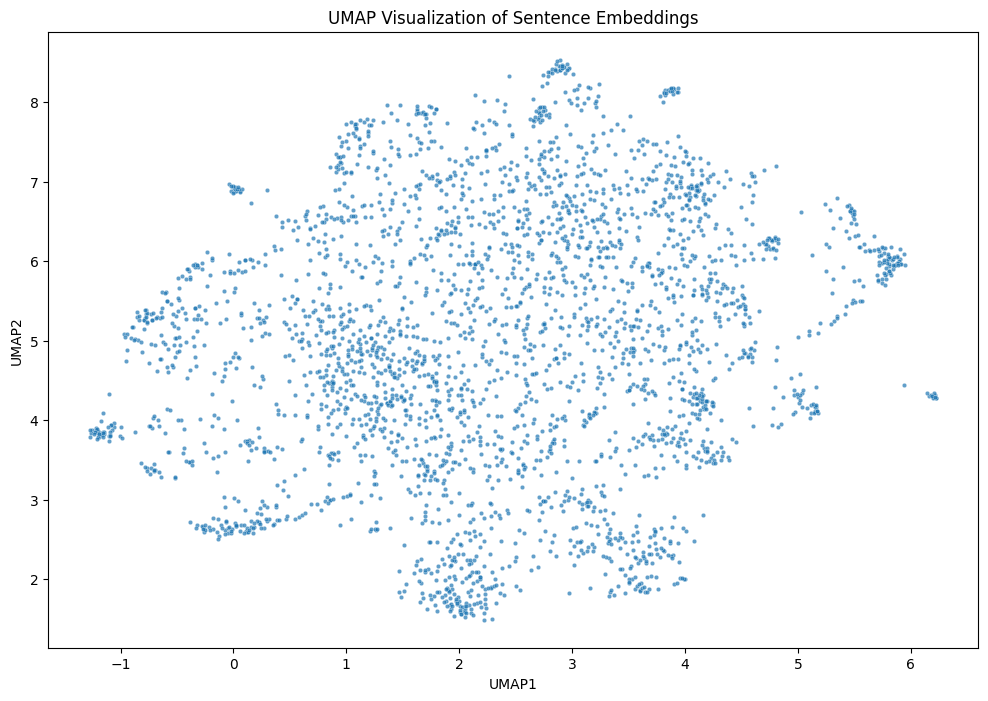

Spearman correlation between original and UMAP distances: 0.2342


In [11]:
# 차원축소 후 데이터의 분포도 시각화
umap_model = UMAP(n_neighbors=50, min_dist=0.1, metric='cosine', random_state=42)
umap_embeddings = umap_model.fit_transform(train_embeddings)

# UMAP 임베딩을 DataFrame으로 변환
umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP1', 'UMAP2'], index=train_dataset)

# UMAP 임베딩 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', s=10, alpha=0.7)
plt.title('UMAP Visualization of Sentence Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# 원래의 코사인 거리
original_dist = pairwise_distances(train_embeddings, metric='cosine')

# UMAP된 코사인 거리
umap_dist = pairwise_distances(umap_embeddings, metric='cosine')

# 거리 간의 스피어만 상관관계 (거리 보존 정도)
corr, _ = spearmanr(original_dist.ravel(), umap_dist.ravel())
print(f"Spearman correlation between original and UMAP distances: {corr:.4f}")

##### **3차원으로 축소후 데이터 시각화**

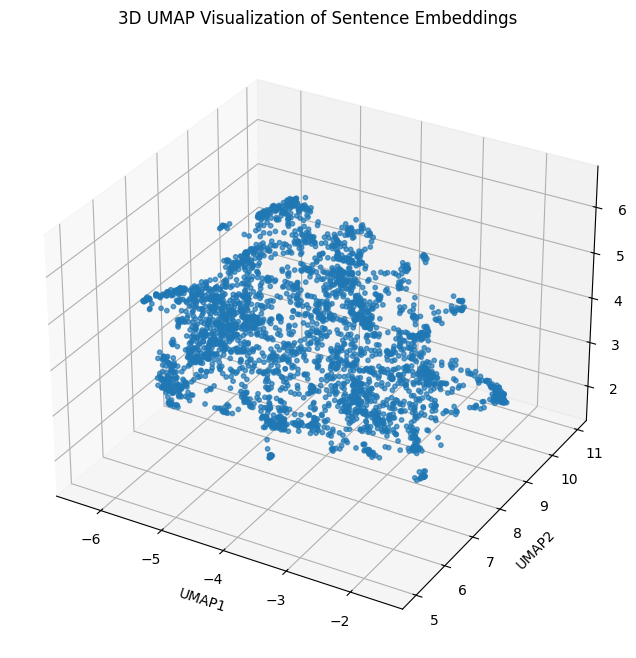

Spearman correlation between original and UMAP distances: 0.2472


In [12]:
# 3D UMAP
umap_model_3d = UMAP(n_neighbors=30, min_dist=0.05, metric='cosine', n_components=3, random_state=42)
umap_embeddings_3d = umap_model_3d.fit_transform(train_embeddings)

# DataFrame 변환
umap_df_3d = pd.DataFrame(umap_embeddings_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=train_dataset)

# 3D 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_df_3d['UMAP1'], umap_df_3d['UMAP2'], umap_df_3d['UMAP3'], s=10, alpha=0.7)

ax.set_title('3D UMAP Visualization of Sentence Embeddings')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.show()

# 원래의 코사인 거리
original_dist = pairwise_distances(train_embeddings, metric='cosine')

# UMAP된 코사인 거리
umap_dist = pairwise_distances(umap_embeddings_3d, metric='cosine')

# 거리 간의 스피어만 상관관계 (거리 보존 정도)
corr, _ = spearmanr(original_dist.ravel(), umap_dist.ravel())
print(f"Spearman correlation between original and UMAP distances: {corr:.4f}")

## **K-Nearest Neighbor(K-최근접 이웃)**

Validation Dataset으로 해당 텍스트와 가장 근접한 텍스트를 추출하기 위해 **k-최근접 이웃(k-NN)** 알고리즘을 사용하였다.

k-NN은 문장 임베딩 간의 거리(또는 유사도)를 기준으로 가장 유사한 이웃 텍스트를 선택하는 데 유용하며, 주어진 문장에 대해 훈련 데이터 내에서 의미적으로 가장 가까운 문장을 탐색하는 데 활용되었다.

특히, cosine similarity를 기반으로 하여 고차원 임베딩 공간에서도 비교적 직관적인 유사도 판단이 가능하다는 장점이 있다.

#### **Cosine Similarity 기반 검증 데이터의 최근접 이웃 찾기**

In [13]:
# 모델 학습
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine')
nn_model.fit(train_embeddings)

# 검증 데이터로 이웃 검색
distances, indices = nn_model.kneighbors(val_embeddings)

# 거리 → 유사도
similarities = 1 - distances

# 예시로 첫 번째 문장과 가장 유사한 5개 출력 (자기 자신 제외)
query_index = 20
print(f"Query: {val_dataset.iloc[query_index]}")
for i in range(1, 6):  # i=0은 자기 자신
    idx = indices[query_index][i]
    print(f"Top {i}: {train_dataset.iloc[idx]} (유사도: {similarities[query_index][i]:.4f})")

Query: 오락실 펀치기계 점수 높게 나올 것 같은 사람
Top 1: 놀때 가장 텐션이 높은사람. (유사도: 0.6469)
Top 2: 오락실 펀치기계에 진심일 것 같은 사람은? (유사도: 0.5919)
Top 3: 밸런스 게임하면 잘 맞을 것 같은 사람 (유사도: 0.5888)
Top 4: 내가 플러팅하면 넘어올 것 같은 사람은? (유사도: 0.5874)
Top 5: 놀이기구 탈 때 제일 소리 지르는 사람 (유사도: 0.5775)


#### **KoNLPy를 통한 질문 필터링**

현재 유사도를 보면 각 질문들 내용중에서 가장 유사한 내용들을 출력하고 있지만, 해당하는 문장 내 명사를 통해서 추천되는 기반을 보이고 있다.

이 빈도를 줄이기 위해 해당 질문에서 핵심 키워드가 되는 단어를 제외하고 질문을 추천해주는 알고리즘을 추가로 진행하였다.

In [14]:
# 형태소 분석기로 단어 추출
okt = Okt()
query_index = 51
query = val_dataset.iloc[query_index]
query_nouns = set([noun for noun in okt.nouns(query) if noun not in {'사람', '가장'}])

# 추천된 문장에서 형태소 추출 및 비교
def has_overlap(sentence, query_nouns):
    sentence_nouns = set(okt.nouns(sentence))
    return not query_nouns.isdisjoint(sentence_nouns)  # 겹치는 단어가 1개라도 있으면 True

# 필터링하여 유사도 높은 문장 출력
results = []
print(f"Query: {query}")
for i in range(1, 6):  # 20개 후보 중에서
    idx = indices[query_index][i]
    candidate = train_dataset.iloc[idx]
    
    if has_overlap(candidate, query_nouns):  # 이제는 "겹치는 것만" 포함
        results.append((candidate, similarities[query_index][i]))
    
    if len(results) == 5:
        break

# 출력
for i, (text, score) in enumerate(results):
    print(f"Top {i+1}: {text} (유사도: {score:.4f})")

Query: 유튜브 100만구독자 달성할 것 같은 사람은?
Top 1: 릴스 100만뷰 찍을 것 같은 사람은? (유사도: 0.6622)
Top 2: 뷰티 유튜버로 성공 할 것 같은 사람은? (유사도: 0.5863)
Top 3: 유튜브 같이 하고 싶은 사람은? (유사도: 0.5791)
Top 4: 옛날에 유튜브해봤을 것 같은 사람은? (유사도: 0.5723)
Top 5: 유튜브 같이 하고싶은 친구는? (유사도: 0.5451)


# **Gemini API를 통한 텍스트 카테고리 생성**

텍스트 클러스터링을 `KMeans`, `DBSCAN` 등으로 지정해줄 수 없는 고차원적인 데이터의 특성을 반영하여, Vertex AI를 통해 해당 질문을 프롬프트에 넘겨 자동으로 장르를 정해주는 태그 방식의 클러스터링을 진행하였다.

## **Vertex AI 모델 로드**

In [40]:
# .env 파일에서 환경변수 불러오기
dotenv.load_dotenv(dotenv.find_dotenv())

# 환경변수에서 프로젝트 ID 불러오기
project_id = dotenv.get_key(dotenv.find_dotenv(), "GOOGLE_PROJECT_ID")
credentials_path = dotenv.get_key(dotenv.find_dotenv(), "GOOGLE_APPLICATION_CREDENTIALS")

# Vertex AI 초기화
vertexai.init(
    project=project_id,
    location="us-central1"
)

model = GenerativeModel(model_name='gemini-2.5-pro')

## **Prompt 실행 함수**

In [49]:
# 프롬프트 함수 정의
def create_prompt(text):
    user_message = f"""
    다음 문장의 핵심 주제와 관련된 카테고리 3가지를 명사형으로 리스트로 추출해줘.
    답변은 무조건 무조건 출력 예시와 같은 내용으로 단답형으로 말해줘.

    문장 : '{text}'

    출력 예시 : [카테고리1, 카테고리2, 카테고리3]
    """
    try:
        resp = model.generate_content(user_message)
        return resp.text.strip()
    except Exception as e:
        return f"ERROR: {e}"

## **출력된 Prompt 데이터를 polls_question 데이터에 추가**

In [50]:
query = """
SELECT *
FROM `votes.polls_question`
"""

# 데이터 불러오기
origin_df = load_data_from_bigquery(query)

# 데이터 리스트
question_list = origin_df['question_text'].tolist()

Downloading: 100%|██████████|


In [51]:
# 병렬 실행
category_data_list = []
max_workers = 10  # 동시에 몇 개씩 실행할지 설정

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(create_prompt, question) for question in question_list]

    for idx, future in enumerate(concurrent.futures.as_completed(futures)):
        result = future.result()
        category_data_list.append(result)
        print(f"{idx + 1}/{len(question_list)} 완료")

        # 중간 저장 (선택)
        if (idx + 1) % 50 == 0:
            with open("checkpoint.json", "w", encoding="utf-8") as f:
                json.dump(category_data_list, f, ensure_ascii=False)

1/5025 완료
2/5025 완료
3/5025 완료
4/5025 완료
5/5025 완료
6/5025 완료
7/5025 완료
8/5025 완료
9/5025 완료
10/5025 완료
11/5025 완료
12/5025 완료
13/5025 완료
14/5025 완료
15/5025 완료
16/5025 완료
17/5025 완료
18/5025 완료
19/5025 완료
20/5025 완료
21/5025 완료
22/5025 완료
23/5025 완료
24/5025 완료
25/5025 완료
26/5025 완료
27/5025 완료
28/5025 완료
29/5025 완료
30/5025 완료
31/5025 완료
32/5025 완료
33/5025 완료
34/5025 완료
35/5025 완료
36/5025 완료
37/5025 완료
38/5025 완료
39/5025 완료
40/5025 완료
41/5025 완료
42/5025 완료
43/5025 완료
44/5025 완료
45/5025 완료
46/5025 완료
47/5025 완료
48/5025 완료
49/5025 완료
50/5025 완료
51/5025 완료
52/5025 완료
53/5025 완료
54/5025 완료
55/5025 완료
56/5025 완료
57/5025 완료
58/5025 완료
59/5025 완료
60/5025 완료
61/5025 완료
62/5025 완료
63/5025 완료
64/5025 완료
65/5025 완료
66/5025 완료
67/5025 완료
68/5025 완료
69/5025 완료
70/5025 완료
71/5025 완료
72/5025 완료
73/5025 완료
74/5025 완료
75/5025 완료
76/5025 완료
77/5025 완료
78/5025 완료
79/5025 완료
80/5025 완료
81/5025 완료
82/5025 완료
83/5025 완료
84/5025 완료
85/5025 완료
86/5025 완료
87/5025 완료
88/5025 완료
89/5025 완료
90/5025 완료
91/5025 완료
92/5025 

## **출력된 데이터를 정제 후 데이터 추가**

In [52]:
category_data_array = np.array(category_data_list)

cleaned_list = []
for item in category_data_array:
    # 괄호 안의 요소 추출 및 한글만 남기기
    item = item.strip() # 줄바꿈 제거
    korean_words = re.findall(r'[가-힣]+', item) # 한글만 추출
    cleaned_list.append(korean_words)

In [53]:
origin_df['category'] = cleaned_list

display(origin_df.iloc[9]['category'])

e:\Visual Studio Code\codeit\advanced_project-1\advanced_project\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


['와플', '친구', '취향']

In [54]:
okt = Okt()

# 제거할 단어 목록
exclude_words = ['안에', '리스트', '형식으로', '담아서', '답변해줘', '답은', '한', '줄로', '부탁해']

def remove_adjectives_and_excludes(words):
    if not isinstance(words, (list, set)):
        return []
    
    cleaned = []
    for word in words:
        # 불필요 단어 제거
        if word in exclude_words:
            continue

        # 형태소 분석 후 형용사인지 확인
        pos_tags = okt.pos(word, norm=True, stem=True)
        if not any(pos == 'Adjective' for _, pos in pos_tags):
            cleaned.append(word)

    return set(cleaned)

# 적용
origin_df['category'] = origin_df['category'].apply(remove_adjectives_and_excludes)

display(origin_df.head(30))

,id,question_text,created_at,category
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,"{외모, 성격, 능력}"
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53,"{동경, 인생, 롤모델}"
2,101,미래의 틱톡커는?,2023-03-31 15:22:54,"{성격, 인간관계, 호감}"
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54,"{위로, 의지, 관계}"
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55,"{신비, 매력, 인물}"
5,104,내 어깨를 내어줄 수 있는 사람은?,2023-03-31 15:22:56,"{애교, 성격, 인상}"
6,105,볼 한 번 눌러보고 싶은 사람은?,2023-03-31 15:22:57,"{미래, 트렌드, 크리에이터}"
7,106,은근히 애교가 많을 것 같은 사람은?,2023-03-31 15:22:57,"{보호, 사랑, 관계}"
8,107,누가 봐도 좋아할 것 같은 호감인 사람은?,2023-03-31 15:22:57,"{충동, 애정, 귀여움}"
9,108,가장 매력적인 사람은?,2023-03-31 15:22:58,"{친구, 취향, 와플}"


## **BigQuery에 업로드**

In [55]:
credentials = service_account.Credentials.from_service_account_file('config/advanced-project-460701-f8c23d3473cb.json')
project_id = dotenv.get_key(dotenv.find_dotenv(), 'GOOGLE_PROJECT_ID')
table_id = f"{project_id}.votes.polls_question_add_category"

client = bigquery.Client(credentials=credentials, project=project_id)

job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
    autodetect=True,
)

job = client.load_table_from_dataframe(origin_df, table_id, job_config=job_config)
job.result()

print("BigQuery Upload Completed")

BigQuery Upload Completed


BigQuery Upload Completed라고 출력되어 있으므로 앞으로 카테고리를 확인할 떄는 그냥 `votes.polls_question_add_category` 테이블을 출력하면 잘 나올 것.

# **Vertex AI로 출력된 카테고리 분석**

## **필요한 데이터 import**

In [56]:
query = """
SELECT *
FROM `votes.polls_question_add_category`
"""

# 데이터 불러오기
polls_question_df = load_data_from_bigquery(query)

display(polls_question_df)

Downloading: 100%|██████████|


,id,question_text,created_at,category
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,"[외모, 성격, 능력]"
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53,"[동경, 인생, 롤모델]"
2,101,미래의 틱톡커는?,2023-03-31 15:22:54,"[성격, 인간관계, 호감]"
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54,"[위로, 의지, 관계]"
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55,"[신비, 매력, 인물]"
...,...,...,...,...
5020,5129,나에게 가장 중요한 사람은?,2023-06-06 06:15:52,"[거리감, 아우라, 비주얼]"
5021,5130,오목을 제일 잘 할 것 같은 사람은?,2023-06-06 06:15:52,"[연애, 호감, 관계]"
5022,5131,가방에서 쓰레기가 안 나올 것 같은 사람은?,2023-06-06 06:15:52,"[성격, 청결, 정리]"
5023,5132,아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는?,2023-06-06 06:15:52,"[효율성, 집중력, 능력, 학습]"


## **가장 인기가 있는 Category는 무엇일까?**

e:\Visual Studio Code\codeit\advanced_project-1\advanced_project\lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
e:\Visual Studio Code\codeit\advanced_project-1\advanced_project\lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
e:\Visual Studio Code\codeit\advanced_project-1\advanced_project\lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.r

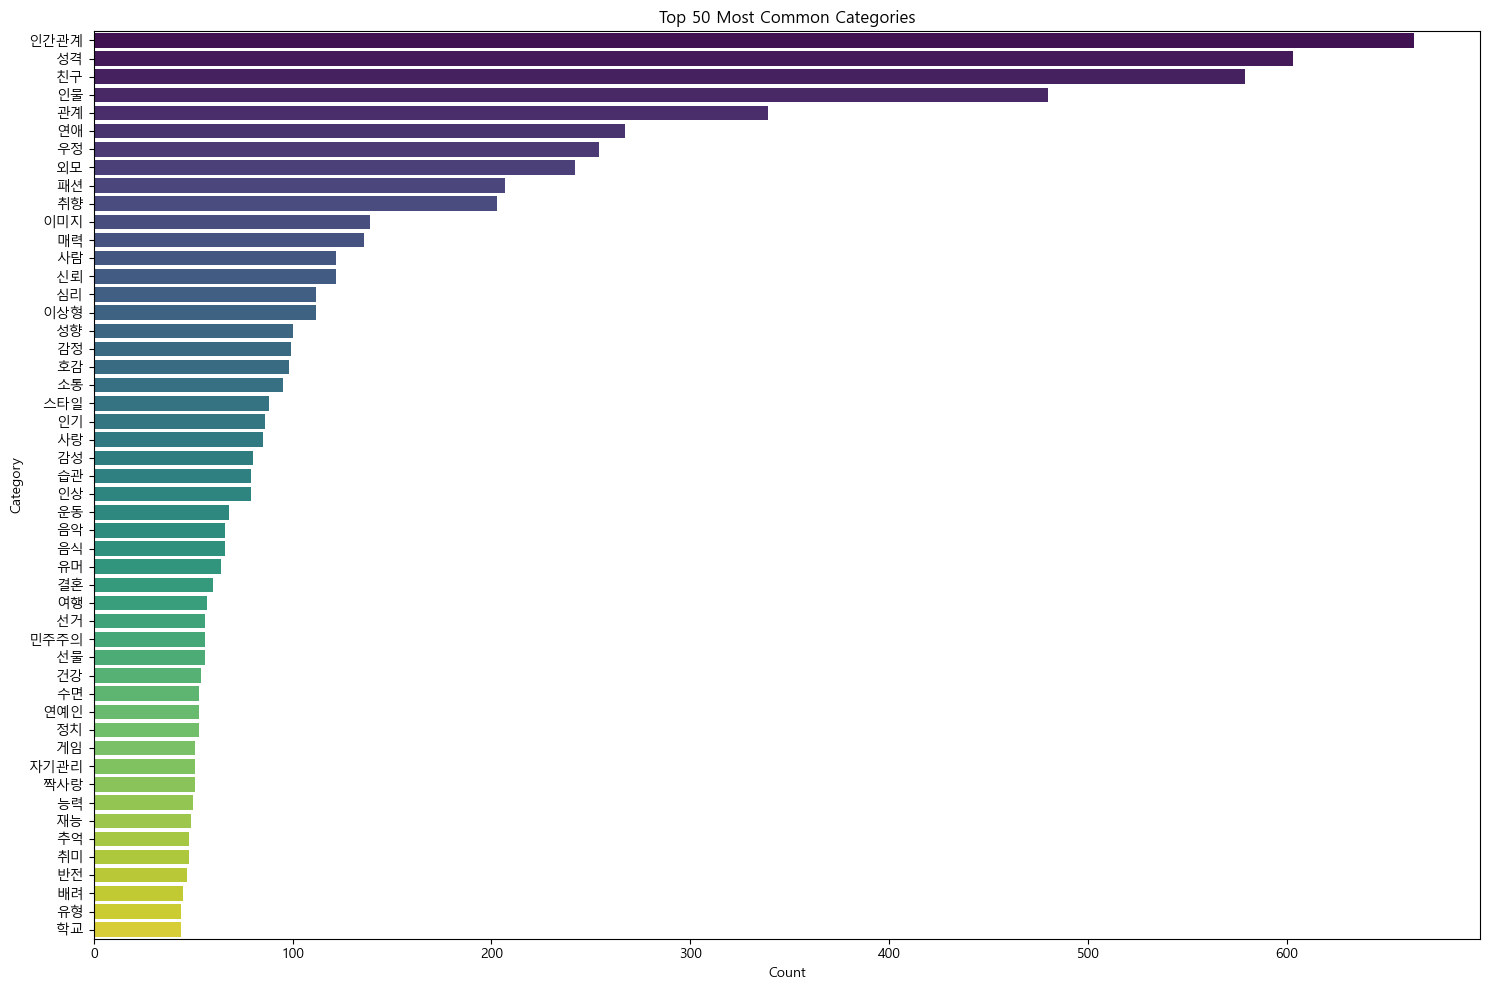

,category
인간관계,664
성격,603
친구,579
인물,480
관계,339
연애,267
우정,254
외모,242
패션,207
취향,203


In [57]:
# 카테고리 폭발 후 상위 50개 카운트
top_categories = polls_question_df.explode('category')['category'].value_counts().head(50)

# barplot으로 시각화
plt.figure(figsize=(15, 10))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.xlabel("Count")
plt.ylabel("Category")
plt.title("Top 50 Most Common Categories")
plt.tight_layout()
plt.show()

display(pd.DataFrame(top_categories))

## **단어간 의미에 따른 클러스터링을 할 수 있을까?**

In [58]:
text_one_hot = pd.get_dummies(
    polls_question_df.explode('category'),
    columns=['category']).groupby(['id', 'question_text', 'created_at']).sum().reset_index()

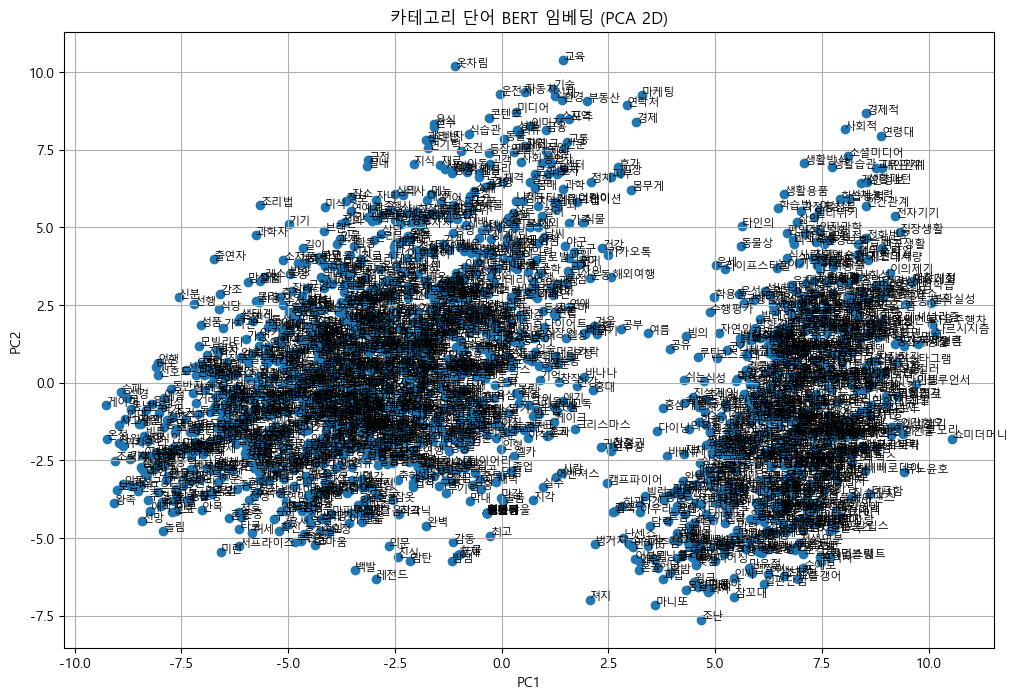

In [59]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModel.from_pretrained("klue/bert-base")

def get_word_embedding(word):
    inputs = tokenizer(word, return_tensors="pt")
    outputs = model(**inputs)
    # token embeddings 평균 (단어 기준)
    return outputs.last_hidden_state[0][1:-1].mean(dim=0).detach()

# 예: explode된 DataFrame의 category 컬럼 사용
# category_df는 한 열짜리 시리즈 또는 DataFrame의 컬럼
category_words = polls_question_df.explode("category")["category"].dropna().unique()

# 중복 제거한 카테고리 단어별 임베딩
embeddings = [get_word_embedding(word) for word in category_words]

# 차원 축소 (시각화용)
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# 시각화
plt.figure(figsize=(12, 8))
plt.scatter(reduced[:, 0], reduced[:, 1])

for i, word in enumerate(category_words):
    plt.text(reduced[i, 0], reduced[i, 1], word, fontsize=8)

plt.title("카테고리 단어 BERT 임베딩 (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

이번에도 사실상 의미있는 클러스터의 경계선을 찾을 수 없었다. 그래서 AI를 통해 출력된 카테고리를 통해서 연관 분석을 진행하면 클러스터가 될까? 에 대한 내용을 적용시켜보고자 함.

## **연관분석을 통한 텍스트 클러스터링**

In [60]:
# category만 불러옴
question_series = polls_question_df['category']
question_series

0             [외모, 성격, 능력]
1            [동경, 인생, 롤모델]
2           [성격, 인간관계, 호감]
3             [위로, 의지, 관계]
4             [신비, 매력, 인물]
               ...        
5020       [거리감, 아우라, 비주얼]
5021          [연애, 호감, 관계]
5022          [성격, 청결, 정리]
5023    [효율성, 집중력, 능력, 학습]
5024          [사랑, 감성, 편지]
Name: category, Length: 5025, dtype: object

In [61]:
encoder = TransactionEncoder()
encoder_T = encoder.fit_transform(question_series)
encoder_matrix = pd.DataFrame(encoder_T, columns= encoder.columns_) * 1
display(encoder_matrix)

,가구,가능성,가방,가상,가성비,가수,가스라이팅,가식,가위바위보,가을,...,희망,희생,희생정신,히어로,히키코모리,힌트,힐링,힘,힘자랑,힙합
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5021,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5022,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
frequent_itemsets = apriori(encoder_matrix, min_support=0.001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

e:\Visual Studio Code\codeit\advanced_project-1\advanced_project\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [63]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(가족),(관계),0.006766,0.067463,0.001791,0.264706,3.923738,1.0,0.001335,1.268251,0.750217,0.024725,0.211512,0.145627
1,(관계),(가족),0.067463,0.006766,0.001791,0.026549,3.923738,1.0,0.001335,1.020322,0.799047,0.024725,0.019917,0.145627
2,(성격),(가족),0.120000,0.006766,0.001194,0.009950,1.470588,1.0,0.000382,1.003216,0.363636,0.009509,0.003206,0.093210
3,(가족),(성격),0.006766,0.120000,0.001194,0.176471,1.470588,1.0,0.000382,1.068571,0.322180,0.009509,0.064171,0.093210
4,(가치관),(결혼),0.008557,0.011940,0.001393,0.162791,13.633721,1.0,0.001291,1.180182,0.934650,0.072917,0.152673,0.139729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,"(우정, 인간관계)",(신뢰),0.009950,0.024279,0.001393,0.140000,5.766393,1.0,0.001151,1.134560,0.834889,0.042424,0.118601,0.098689
600,"(인간관계, 신뢰)",(우정),0.008557,0.050547,0.001393,0.162791,3.220564,1.0,0.000960,1.134069,0.695446,0.024138,0.118219,0.095175
601,(우정),"(인간관계, 신뢰)",0.050547,0.008557,0.001393,0.027559,3.220564,1.0,0.000960,1.019540,0.726203,0.024138,0.019166,0.095175
602,(신뢰),"(우정, 인간관계)",0.024279,0.009950,0.001393,0.057377,5.766393,1.0,0.001151,1.050314,0.847149,0.042424,0.047903,0.098689


여기서 `Support`, `Confidence`, `Lift`정의는 다음과 같다.
- `Support (지지도)` : 전체 내역 중 A와 B가 동시에 포함된 비율
- `Confidence (신뢰도)` : A가 등장했을 때, B가 추가로 등장할 확률
- `Lift (향상도)` : A가 등장했을 때, B가 추가로 등장할 가능성에 관한 지표

여기서 `Lift`값을 가중치를 두어 의미연결망을 구성하고자 하였다.

> Q. 왜 `Lift`값을 가중치를 두었는가?<br/>
> 
> A. `Support`와 `Confidence`는 항목 간의 동시 발생 빈도나 조건부 확률에 기반한 지표로, **빈도 중심의 관계성**을 보여주는 데 그친다. 예를 들어 A와 B가 자주 함께 등장한다는 것은 유의미해 보이지만, 각각이 워낙 자주 등장하는 항목이라면 단순 동시 빈도는 우연한 공존일 가능성도 있다.
>
> 반면, `Lift`는 두 항목의 동시 발생이 우연이 아닌지를 측정하는 지표로, A와 B가 독립일 때 기대되는 발생 확률 대비 실제 발생 확률의 비율을 나타낸다.
>
> 즉, `Lift` 값이 1보다 크면 A와 B는 **우연 이상의 상관관계**를 가진다고 볼 수 있고, 이는 의미망 분석에서 단어 간의 실제적 연관성을 가늠하는 데 더 적합하다고 판단하였다.
>
> 따라서, 단순히 많이 등장했다고 해서 의미가 연결된다고 판단하기보다는, `Lift`를 통해 실질적 의미 연관성을 기반으로 텍스트 카테고리들 간의 네트워크를 구성하고자 하였다.

In [64]:
G = nx.Graph()

# 연관 규칙을 노드-엣지로 변환
for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            if G.has_edge(antecedent, consequent):
                G[antecedent][consequent]['weight'] += row['lift']
            else:
                G.add_edge(antecedent, consequent, weight=row['lift'])

e:\Visual Studio Code\codeit\advanced_project-1\advanced_project\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


**community** 라는 라이브러리를 통해 의미연결망 내의 데이터를 자동으로 군집화 시켜보았다.

> Q1. `community` 라이브러리는 무엇인가?
>
> A1. 공식 이름은 `python-louvain`이며, 네트워크에서 커뮤니티 탐색을 위한 Louvain 알고리즘을 구현한 파이썬 라이브러리이다.


> Q2. `Louvain 알고리즘` 이란?
>
> A2. 네트워크(그래프)에서 의미 있는 그룹(커뮤니티)을 찾기 위한 군집 알고리즘이다.<br/>
>> 핵심 아이디어:
>> 그래프에서 **서로 밀접하게 연결된 노드 집단(커뮤니티)**을 찾는다.
>> 
>> 이때 사용되는 지표가 Modularity (모듈성):
>> 
>> - "내부 연결은 조밀하고, 외부 연결은 드문" 구조일수록 모듈성이 높다.
>> 
> 작동 방식 요약:
> 1. 각 노드를 하나의 커뮤니티로 시작.
> 
> 2. 각 노드를 옮겨가며 모듈성(Modularity)을 가장 크게 높이는 방향으로 이동.
> 
> 3. 커뮤니티를 재구성하고, 노드들을 압축해서 새로운 그래프 구성.
> 
> 4. 이 과정을 모듈성 변화가 더 이상 없을 때까지 반복.


> Q. 왜 의미연결망에 적합한가?
>
> A. 단어들을 **네트워크(노드: 단어, 간선: 의미 연결)**로 표현할 때,
> 
> Louvain 알고리즘은 비슷한 의미로 뭉친 단어들끼리 자동으로 그룹화해 준다.
> 
> 즉, 의미 기반 카테고리 클러스터링에 효과적이다.

In [65]:
partition = community_louvain.best_partition(G, weight='weight')

# 클러스터 결과 보기
clusters = defaultdict(list)
for node, comm in partition.items():
    clusters[comm].append(node)

for comm_id, tags in clusters.items():
    print(f"Cluster {comm_id}: {tags}")

Cluster 7: ['가족', '관계', '감성', '낭만', '여행', '음악', '감정', '우정', '위로', '소통', '공감', '관심', '그리움', '선택', '신뢰', '애정', '약속', '유대감', '추억', '책임감', '리더십', '비밀', '우선순위', '의리', '플레이리스트']
Cluster 15: ['성격', '호감', '연애', '이상형', '경험', '고백', '고정관념', '취향', '궁합', '긍정', '라이프스타일', '매력', '반전', '첫인상', '사람', '심리', '애교', '유형', '정리', '태도', '행동', '성향', '소비', '식습관', '질투', '짝사랑', '음식', '카페', '편식']
Cluster 1: ['가치관', '결혼', '배우자']
Cluster 3: ['인간관계', '갈등', '기억', '내향성', '만남', '인기', '소셜', '미디어', '사회성', '선호', '연락', '인성', '죽음', '친밀감', '친화력', '편안함', '화법', '학교']
Cluster 8: ['개성', '패션', '인물', '닮은꼴', '외모', '마스크', '목소리', '미모', '미용', '분위기', '뷰티', '사진', '선호도', '인상', '순위', '스타일', '이미지', '스타일링', '신체', '연예인', '헤어스타일', '요리', '유행', '퍼스널컬러', '퀴즈', '투표', '특징', '평가', '표정', '코디']
Cluster 11: ['건강', '운동', '자기관리', '근력', '능력', '청결', '향기']
Cluster 2: ['수면', '습관', '잠버릇', '피로', '휴식', '집순이']
Cluster 12: ['게임', '밸런스']
Cluster 13: ['친구', '생일', '선물', '귀여움', '기념일', '대화', '말투', '반응', '유머', '취미', '시험', '장난', '재능', '주사', '캐릭터', '학원']
Cluster 14: ['고민',

[ 질문 text 여러개 읽어보고 위의 클러스터 0~3번 중, 질문 카테고리 10개로 나뉘면 좋을거 같은 키워드들 기재해주세요 ]

- GPT :

    | 대표 카테고리 | 근거가 된 클러스터 |
    | --- | --- |
    | **심리/사회관계** | Cluster 0 (심리, 감정, 우정, 인간관계 등) |
    | **예능/게임/오락** | Cluster 0 (예능, 유머, 게임, 퀴즈 등) |
    | **문학/소설/드라마** | Cluster 2 (소설, 드라마, 웹소설 등) |
    | **성장/청소년** | Cluster 2 (청춘, 성장, 학원 등) |
    | **연애/로맨스** | Cluster 2 + 3 (로맨스, 사랑, 감성) |
    | **패션/취향/스타일** | Cluster 4 (취향, 스타일, 패션 등) |
    | **미래/직업/능력** | Cluster 4 (미래, 직업, 능력 등) |
    | **문화/예술/음악** | Cluster 4 (문화, 예술, 음악 등) |
    | **정치/사회 의견** | Cluster 1 (정치, 투표, 의견) |
    | **판타지/상상력** | Cluster 2 + 0 (판타지, 상상력, 가상 등) |

- 민준 : 연애, 일상, 인간관계, 추측, 친구, 상상력, 성격, 대화, 놀이, 관찰
- 은영 : 성향, 인간관계, 연애, 사회, 상상, 미디어, 일상, 감성, 취향, 패션
- 우성 : 친구, 연애, 고민, 관계, 성격, 일상, 공감, 대화, 유형, 관찰
- 희진 : 인간관계, 스타일, 철학, 친구, 연애, 관찰, 상상력, 추리, 상황, 일상
- 수민 : 연애, 미래, 운동, 게임, 예능, 패션, 판타지, 예술, 드라마, 심리
- 금희 : 인간관계, 일상, 라이프스타일, 지식, 소통, 연애, 장르, 심리, 활동, 이야기

## **다시 프롬프트 학습**

In [3]:
# 민준 : 연애, 일상, 인간관계, 추측, 친구, 상상력, 성격, 대화, 놀이, 관찰
# 은영 : 성향, 인간관계, 연애, 사회, 상상, 미디어, 일상, 감성, 취향, 패션
# 우성 : 친구, 연애, 고민, 관계, 성격, 일상, 공감, 대화, 유형, 관찰
# 희진 : 인간관계, 스타일, 철학, 친구, 연애, 관찰, 상상력, 추리, 상황, 일상
# 수민 : 연애, 미래, 운동, 게임, 예능, 패션, 판타지, 예술, 드라마, 심리
# 금희 : 인간관계, 일상, 라이프스타일, 지식, 소통, 연애, 장르, 심리, 활동, 이야기

minjoon_list = ['연애', '일상', '인간관계', '추측', '친구', '상상력', '성격', '대화', '놀이', '관찰']
eunyoung_list = ['성향', '인간관계', '연애', '사회', '상상', '미디어', '일상', '감성', '취향', '패션']
woosung_list = ['친구', '연애', '고민', '관계', '성격', '일상', '공감', '대화', '유형', '관찰']
heejin_list = ['인간관계', '스타일', '철학', '친구', '연애', '관찰', '상상력', '추리', '상황', '일상']
soomin_list = ['연애', '미래', '운동', '게임', '예능', '패션', '판타지', '예술', '드라마', '심리']
geumhwi_list = ['인간관계', '일상', '라이프스타일', '지식', '소통', '연애', '장르', '심리', '활동', '이야기']


# 모든 리스트를 합쳐서 하나의 set으로 만듦
all_unique_keywords = set(
    minjoon_list +
    eunyoung_list +
    woosung_list +
    heejin_list +
    soomin_list +
    geumhwi_list
)

print(all_unique_keywords)
print(f"총 고유 키워드 수: {len(all_unique_keywords)}")

# GPT 선정 가장 최적의 15개 카테고리
point_keywords = ['연애', '인간관계', '일상', '성격', '감성', '상상', '스타일', '미디어', '운동', '지식', '심리', '미래']

{'소통', '성격', '활동', '라이프스타일', '상상력', '지식', '놀이', '철학', '고민', '이야기', '친구', '관계', '대화', '미디어', '상상', '취향', '미래', '예능', '판타지', '성향', '연애', '감성', '관찰', '공감', '추리', '드라마', '패션', '스타일', '인간관계', '일상', '상황', '추측', '게임', '운동', '장르', '사회', '심리', '예술', '유형'}
총 고유 키워드 수: 39


In [4]:
# 프롬프트 실행 함수
def create_prompt(question_text, idx):
    # 모델 실행
    query_index = idx
    user_message = f"""
    우리가 지정해놓은 카테고리는 다음과 같아.
    {point_keywords}
    이 중, 해당되는 카테고리 1개 를단답형으로 이야기 해줘.
    
    Q. '{question_text.iloc[query_index]}'
    
    답변은 대괄호 안에 리스트 형식으로 담아서 답변해주고, 명사만 출력해줘.
    """
    model = GenerativeModel(model_name='gemini-2.0-flash-lite')
    resp = model.generate_content(user_message)

    return resp.text

In [7]:
category_data_list = []

for idx in range(len(origin_df['question_text'].values)):
    category_data = create_prompt(origin_df['question_text'], idx)
    category_data_list.append(category_data)
    time.sleep(0.1)

In [8]:
category_data_list

['[상상]\n',
 '[상상]\n',
 '[미래]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[일상]\n',
 '[성격]\n',
 '[인간관계]\n',
 '[성격]\n',
 '[일상]\n',
 '[상상]\n',
 '[스타일]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[성격]\n',
 '[인간관계]\n',
 '[미래]\n',
 '[인간관계]\n',
 '[일상]\n',
 '[인간관계]\n',
 '[스타일]\n',
 '[성격]\n',
 "['인간관계']\n",
 '[인간관계]\n',
 '[인간관계]\n',
 '[미래]\n',
 '[연애]\n',
 '[인간관계]\n',
 '[연애]\n',
 '[스타일]\n',
 '[일상]\n',
 '[연애]\n',
 '[연애]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[연애]\n',
 '[인간관계]\n',
 '[연애]\n',
 '[연애]\n',
 '[지식]\n',
 '[지식]\n',
 '[지식]\n',
 '[일상]\n',
 '[인간관계]\n',
 '[일상]\n',
 '[인간관계]\n',
 '[스타일]\n',
 '[스타일]\n',
 '[스타일]\n',
 '[스타일]\n',
 '[미래]\n',
 '[운동]\n',
 '[일상]\n',
 '[일상]\n',
 '[감성]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[성격]\n',
 '[인간관계]\n',
 '[연애]\n',
 '[미래]\n',
 '[인간관계]\n',
 '[일상]\n',
 '[일상]\n',
 '[성격]\n',
 '[인간관계]\n',
 '[일상]\n',
 '[인간관계]\n',
 '[미디어]\n',
 '[인간관계]\n',
 '[인간관계]\n',
 '[스타일]\n',
 '[스타일]\n',
 '[일상]\n',
 '[스타일]\n',
 '[일상]\n',
 '[지식]\n',
 '[성격]\n',
 '[일상]\n',
 '[인간관계]\n',
 '[

In [9]:
category_data_array = np.array(category_data_list)

cleaned_list = []
for item in category_data_array:
    # 괄호 안의 요소 추출 및 한글만 남기기
    item = item.strip() # 줄바꿈 제거
    korean_words = re.findall(r'[가-힣]+', item) # 한글만 추출
    cleaned_list.append(korean_words)

In [10]:
cleaned_list

[['상상'],
 ['상상'],
 ['미래'],
 ['인간관계'],
 ['인간관계'],
 ['인간관계'],
 ['일상'],
 ['성격'],
 ['인간관계'],
 ['성격'],
 ['일상'],
 ['상상'],
 ['스타일'],
 ['인간관계'],
 ['인간관계'],
 ['성격'],
 ['인간관계'],
 ['미래'],
 ['인간관계'],
 ['일상'],
 ['인간관계'],
 ['스타일'],
 ['성격'],
 ['인간관계'],
 ['인간관계'],
 ['인간관계'],
 ['미래'],
 ['연애'],
 ['인간관계'],
 ['연애'],
 ['스타일'],
 ['일상'],
 ['연애'],
 ['연애'],
 ['인간관계'],
 ['인간관계'],
 ['연애'],
 ['인간관계'],
 ['연애'],
 ['연애'],
 ['지식'],
 ['지식'],
 ['지식'],
 ['일상'],
 ['인간관계'],
 ['일상'],
 ['인간관계'],
 ['스타일'],
 ['스타일'],
 ['스타일'],
 ['스타일'],
 ['미래'],
 ['운동'],
 ['일상'],
 ['일상'],
 ['감성'],
 ['인간관계'],
 ['인간관계'],
 ['인간관계'],
 ['인간관계'],
 ['인간관계'],
 ['성격'],
 ['인간관계'],
 ['연애'],
 ['미래'],
 ['인간관계'],
 ['일상'],
 ['일상'],
 ['성격'],
 ['인간관계'],
 ['일상'],
 ['인간관계'],
 ['미디어'],
 ['인간관계'],
 ['인간관계'],
 ['스타일'],
 ['스타일'],
 ['일상'],
 ['스타일'],
 ['일상'],
 ['지식'],
 ['성격'],
 ['일상'],
 ['인간관계'],
 ['인간관계'],
 ['미디어'],
 ['인간관계'],
 ['미디어'],
 ['인간관계'],
 ['지식'],
 ['성격'],
 ['운동'],
 ['일상'],
 ['연애'],
 ['상상'],
 ['일상'],
 ['인간관계'],
 ['인간관계'],
 ['상상'],
 ['스타일'],
 ['일상'],
 ['인간관계

In [11]:
origin_df['category'] = cleaned_list

display(origin_df.iloc[9]['category'])

e:\Visual Studio Code\codeit\advanced_project-1\advanced_project\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


['성격']

In [12]:
okt = Okt()

# 제거할 단어 목록
exclude_words = ['안에', '리스트', '형식으로', '담아서', '답변해줘', '답은', '한', '줄로', '부탁해']

def remove_adjectives_and_excludes(words):
    if not isinstance(words, (list, set)):
        return []
    
    cleaned = []
    for word in words:
        # 불필요 단어 제거
        if word in exclude_words:
            continue

        # 형태소 분석 후 형용사인지 확인
        pos_tags = okt.pos(word, norm=True, stem=True)
        if not any(pos == 'Adjective' for _, pos in pos_tags):
            cleaned.append(word)

    return set(cleaned)

# 적용
origin_df['category'] = origin_df['category'].apply(remove_adjectives_and_excludes)

display(origin_df.head(30))

,id,question_text,created_at,category
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53,{상상}
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53,{상상}
2,101,미래의 틱톡커는?,2023-03-31 15:22:54,{미래}
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54,{인간관계}
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55,{인간관계}
5,104,내 어깨를 내어줄 수 있는 사람은?,2023-03-31 15:22:56,{인간관계}
6,105,볼 한 번 눌러보고 싶은 사람은?,2023-03-31 15:22:57,{일상}
7,106,은근히 애교가 많을 것 같은 사람은?,2023-03-31 15:22:57,{성격}
8,107,누가 봐도 좋아할 것 같은 호감인 사람은?,2023-03-31 15:22:57,{인간관계}
9,108,가장 매력적인 사람은?,2023-03-31 15:22:58,{성격}


In [13]:
drop_df = origin_df[origin_df['question_text'] != 'vote']

print(drop_df['category'].explode().nunique())
print(drop_df['category'].explode().unique())

12
['상상' '미래' '인간관계' '일상' '성격' '스타일' '연애' '지식' '운동' '감성' '미디어' '심리']


In [14]:
credentials = service_account.Credentials.from_service_account_file('config/advanced-project-460701-f8c23d3473cb.json')
project_id = dotenv.get_key(dotenv.find_dotenv(), 'GOOGLE_PROJECT_ID')
table_id = f"{project_id}.votes.polls_question_add_category"

client = bigquery.Client(credentials=credentials, project=project_id)

job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
    autodetect=True,
)

job = client.load_table_from_dataframe(origin_df, table_id, job_config=job_config)
job.result()

print("BigQuery Upload Completed")

BigQuery Upload Completed


In [15]:
origin_df.to_parquet('polls_question_add_category.parquet', engine='pyarrow')